In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv

In [2]:
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

In [3]:
#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

In [4]:
def L96_t(X0,X1,F):
    return (np.roll(X0,-1,axis=0) - np.roll(X0,2,axis=0))*np.roll(X1,1,axis=0) + (np.roll(X1,-1,axis=0) - np.roll(X1,2,axis=0))*np.roll(X0,1,axis=0) - X1

def Rungekutta4_t(X0,X1,h,F):
    N=len(X0)
    
    K1 = h*L96(X0,F)
    dK1 = h*L96_t(X0,X1,F)
    
    X2 = X0 + K1/2
    dX2 = X1 + dK1/2
    K2 = h*L96(X2,F)
    dK2 = h*L96_t(X2,dX2,F)
    
    X3 = X0 + K2/2
    dX3 = X1 + dK2/2
    K3 = h*L96(X3,F)
    dK3 = h*L96_t(X3,dX3,F)
    
    X4 = X0 + K3
    dX4 = X1 + dK3
    K4 = h*L96(X4,F)
    dK4 = h*L96_t(X4,dX4,F)
    
    dXb = X1 + dK1/6 + dK2/3 + dK3/3 + dK4/6
    
    return dXb

In [5]:
def L96_adj(dXb,X0,F):
    return np.roll(X0,2,axis=0)*np.roll(dXb,1,axis=0) + (np.roll(X0,-2,axis=0) - np.roll(X0,1,axis=0))*np.roll(dXb,-1,axis=0) - np.roll(X0,-1,axis=0)*np.roll(dXb,-2,axis=0) - dXb

def Rungekutta4_adj(dXb,X0,h,F):
    K1 = h*L96(X0,F)
    X2 = X0 + K1/2
    K2 = h*L96(X2,F)
    X3 = X0 + K2/2
    K3 = h*L96(X3,F)
    X4 = X0 + K3
    K4 = h*L96(X4,F)
    
    X1 = dXb
    dK1 = dXb/6
    dK2 = dXb/3
    dK3 = dXb/3
    dK4 = dXb/6
    #print(X1,dK1,dK2,dK3,dK4)
    
    X1 = X1 + h*L96_adj(dK4,X4,F)
    dK1 = dK1
    dK2 = dK2
    dK3 = dK3 + h*L96_adj(dK4,X4,F)
    #print(X1,dK1,dK2,dK3)
    
    X1 = X1 + h*L96_adj(dK3,X3,F)
    dK1 = dK1
    dK2 = dK2 + h*L96_adj(dK3,X3,F)/2
    #print(X1,dK1,dK2)
    
    X1 = X1 + h*L96_adj(dK2,X2,F)
    dK1 = dK1 + h*L96_adj(dK2,X2,F)/2
    #print(X1,dK1)
    
    X1 = X1 + h*L96_adj(dK1,X0,F)
    #print(X1)
    
    return X1

In [7]:
N=40
m=10
h=0.05
F=8.0
X1 = np.random.rand(N)
X0 = np.ones(N)
Ax = Rungekutta4_t(X0,X1,h,F)
AtAx = Rungekutta4_adj(Ax,X0,h,F)
a = Ax.T@Ax
b = X1.T@AtAx
print(a);print(b)
print(a-b)

10.120219049528819
10.12021904952882
-1.7763568394002505e-15


In [19]:
for i in range(0, 10, 2):
    print(i)
obs = np.arange(10).reshape(5,2)
print(obs[0:2])

0
2
4
6
8
[[0 1]
 [2 3]]


In [38]:
#4dVar with Cholesky decomposition
def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [] #TLM
    Mk = np.eye(N)
    M.append(Mk)
    MT = [] #ADM
    MkT = np.eye(N)
    MT.append(MkT)
    for k in range(a_window):
        xk = Fcst[k].reshape(-1,1)
        Mk_ = Rungekutta4_t(xk,E,h,F)
        MkT_ = Rungekutta4_adj(E,xk,h,F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,M,MT

def J(dv,U,R_inv,H,y,Fcst,M,a_window):
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@U@dv-dk).T@R_inv@(H@Mk@U@dv-dk)/2
    return j+dv.T@dv/2

def jacobi(dv,U,R_inv,H,y,Fcst,M,MT,a_window):
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += U.T@MkT@H_t@R_inv@(H@Mk@U@dv-dk)
         
    return p+dv

def CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window):
    d0 = -jacobi(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    for k in range(1000):
        #alpha = golden_section(d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        alpha=0.01
        dv = dv0 + alpha*d0
        d = jacobi(dv,U,R_inv,H,y,Fcst,M,MT,a_window)
        #err = np.sqrt(np.sum(d**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d**2))<0.001):
            print(k,"end")
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        dv0 = dv
        d0 = p
    return dv

def golden_section(d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window):
    a0=1e-2
    b0=1
    t = (-1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=b-t*(b-a)
    c2=a+t*(b-a)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    while abs(b-a)/2>0.0001:
        num+=1
        f1 = fj(c1,d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        #dv1 = dv0 + c1*d0
        #f1 = J(dv1,U,R_inv,H,y,Fcst,M,a_window)
        f2 = fj(c2,d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        #dv2 = dv0 + c2*d0
        #f2 = J(dv2,U,R_inv,H,y,Fcst,M,a_window)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=b-t*(b-a)
        else:
            a=c1
            b=b
            c1=c2
            c2=a+t*(b-a)
    alpha = (a+b)/2    
    #print(num,"end",alpha)
    return alpha

def fj(c,d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window):
    dv = dv0 + c*d0
    return J(dv,U,R_inv,H,y,Fcst,M,a_window)

[0, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275, 286, 297, 308, 319, 330, 341, 352, 363, 374, 385, 396, 407, 418, 429, 440, 451, 462, 473, 484, 495, 506, 517, 528, 539, 550, 561, 572, 583, 594, 605, 616, 627, 638, 649, 660, 671, 682, 693, 704, 715, 726, 737, 748, 759, 770, 781, 792, 803, 814, 825, 836, 847, 858, 869, 880, 891, 902, 913, 924, 935, 946, 957, 968, 979, 990, 1001, 1012, 1023, 1034, 1045, 1056, 1067, 1078, 1089, 1100, 1111, 1122, 1133, 1144, 1155, 1166, 1177, 1188, 1199, 1210, 1221, 1232, 1243, 1254, 1265, 1276, 1287, 1298, 1309, 1320, 1331, 1342, 1353, 1364, 1375, 1386, 1397]
(11, 40)
11 11
314 end
0
(11, 40)
11 11
284 end
11
(11, 40)
11 11
292 end
22
(11, 40)
11 11
272 end
33
(11, 40)
11 11
277 end
44
(11, 40)
11 11
279 end
55
(11, 40)
11 11
275 end
66
(11, 40)
11 11
283 end
77
(11, 40)
11 11
286 end
88
(11, 40)
11 11
266 end
99
(11, 40)
11 11
270 end
110
(11, 40)
11 11
288 end
121
(11, 40)
11 11
273 e

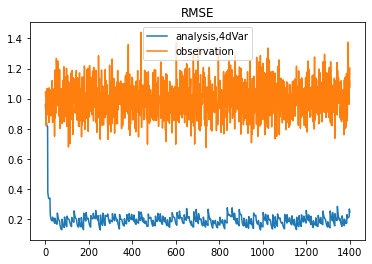

[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300, 312, 324, 336, 348, 360, 372, 384, 396, 408, 420, 432, 444, 456, 468, 480, 492, 504, 516, 528, 540, 552, 564, 576, 588, 600, 612, 624, 636, 648, 660, 672, 684, 696, 708, 720, 732, 744, 756, 768, 780, 792, 804, 816, 828, 840, 852, 864, 876, 888, 900, 912, 924, 936, 948, 960, 972, 984, 996, 1008, 1020, 1032, 1044, 1056, 1068, 1080, 1092, 1104, 1116, 1128, 1140, 1152, 1164, 1176, 1188, 1200, 1212, 1224, 1236, 1248, 1260, 1272, 1284, 1296, 1308, 1320, 1332, 1344, 1356, 1368, 1380, 1392]
(12, 40)
12 12
287 end
0
(12, 40)
12 12
272 end
12
(12, 40)
12 12
277 end
24
(12, 40)
12 12
262 end
36
(12, 40)
12 12
290 end
48
(12, 40)
12 12
280 end
60
(12, 40)
12 12
273 end
72
(12, 40)
12 12
282 end
84
(12, 40)
12 12
267 end
96
(12, 40)
12 12
261 end
108
(12, 40)
12 12
284 end
120
(12, 40)
12 12
270 end
132
(12, 40)
12 12
272 end
144
(12, 40)
12 12
276 end
156
(12, 40)
12 12
276 end


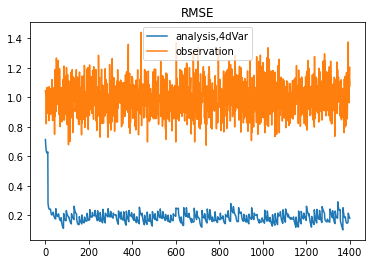

[0, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390, 403, 416, 429, 442, 455, 468, 481, 494, 507, 520, 533, 546, 559, 572, 585, 598, 611, 624, 637, 650, 663, 676, 689, 702, 715, 728, 741, 754, 767, 780, 793, 806, 819, 832, 845, 858, 871, 884, 897, 910, 923, 936, 949, 962, 975, 988, 1001, 1014, 1027, 1040, 1053, 1066, 1079, 1092, 1105, 1118, 1131, 1144, 1157, 1170, 1183, 1196, 1209, 1222, 1235, 1248, 1261, 1274, 1287, 1300, 1313, 1326, 1339, 1352, 1365, 1378, 1391]
(13, 40)
13 13
298 end
0
(13, 40)
13 13
281 end
13
(13, 40)
13 13
274 end
26
(13, 40)
13 13
295 end
39
(13, 40)
13 13
275 end
52
(13, 40)
13 13
272 end
65
(13, 40)
13 13
281 end
78
(13, 40)
13 13
285 end
91
(13, 40)
13 13
265 end
104
(13, 40)
13 13
270 end
117
(13, 40)
13 13
280 end
130
(13, 40)
13 13
277 end
143
(13, 40)
13 13
275 end
156
(13, 40)
13 13
276 end
169
(13, 40)
13 13
273 end
182
(13, 40)
13 13
275 end
195
(13, 40)
13 13

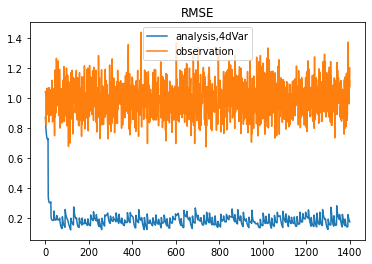

[0, 14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 182, 196, 210, 224, 238, 252, 266, 280, 294, 308, 322, 336, 350, 364, 378, 392, 406, 420, 434, 448, 462, 476, 490, 504, 518, 532, 546, 560, 574, 588, 602, 616, 630, 644, 658, 672, 686, 700, 714, 728, 742, 756, 770, 784, 798, 812, 826, 840, 854, 868, 882, 896, 910, 924, 938, 952, 966, 980, 994, 1008, 1022, 1036, 1050, 1064, 1078, 1092, 1106, 1120, 1134, 1148, 1162, 1176, 1190, 1204, 1218, 1232, 1246, 1260, 1274, 1288, 1302, 1316, 1330, 1344, 1358, 1372, 1386]
(14, 40)
14 14
285 end
0
(14, 40)
14 14
279 end
14
(14, 40)
14 14
282 end
28
(14, 40)
14 14
287 end
42
(14, 40)
14 14
267 end
56
(14, 40)
14 14
267 end
70
(14, 40)
14 14
280 end
84
(14, 40)
14 14
258 end
98
(14, 40)
14 14
256 end
112
(14, 40)
14 14
276 end
126
(14, 40)
14 14
258 end
140
(14, 40)
14 14
276 end
154
(14, 40)
14 14
275 end
168
(14, 40)
14 14
275 end
182
(14, 40)
14 14
280 end
196
(14, 40)
14 14
280 end
210
(14, 40)
14 14
289 end
224
(14, 40)
14 14
256 end
238
(14

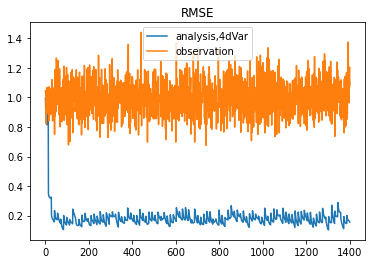

[0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390, 405, 420, 435, 450, 465, 480, 495, 510, 525, 540, 555, 570, 585, 600, 615, 630, 645, 660, 675, 690, 705, 720, 735, 750, 765, 780, 795, 810, 825, 840, 855, 870, 885, 900, 915, 930, 945, 960, 975, 990, 1005, 1020, 1035, 1050, 1065, 1080, 1095, 1110, 1125, 1140, 1155, 1170, 1185, 1200, 1215, 1230, 1245, 1260, 1275, 1290, 1305, 1320, 1335, 1350, 1365, 1380, 1395]
(15, 40)
15 15
267 end
0
(15, 40)
15 15
275 end
15
(15, 40)
15 15
262 end
30
(15, 40)
15 15
278 end
45
(15, 40)
15 15
274 end
60
(15, 40)
15 15
275 end
75
(15, 40)
15 15
286 end
90
(15, 40)
15 15
265 end
105
(15, 40)
15 15
281 end
120
(15, 40)
15 15
263 end
135
(15, 40)
15 15
283 end
150
(15, 40)
15 15
283 end
165
(15, 40)
15 15
274 end
180
(15, 40)
15 15
271 end
195
(15, 40)
15 15
280 end
210
(15, 40)
15 15
287 end
225
(15, 40)
15 15
275 end
240
(15, 40)
15 15
283 end
255
(15, 40)
15 15
270 end
270
(15, 

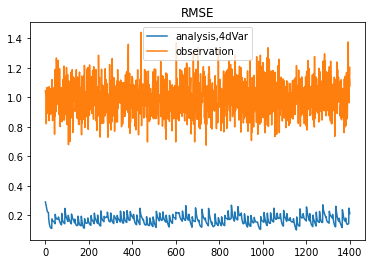

[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800, 816, 832, 848, 864, 880, 896, 912, 928, 944, 960, 976, 992, 1008, 1024, 1040, 1056, 1072, 1088, 1104, 1120, 1136, 1152, 1168, 1184, 1200, 1216, 1232, 1248, 1264, 1280, 1296, 1312, 1328, 1344, 1360, 1376, 1392]
(16, 40)
16 16
302 end
0
(16, 40)
16 16
295 end
16
(16, 40)
16 16
282 end
32
(16, 40)
16 16
289 end
48
(16, 40)
16 16
277 end
64
(16, 40)
16 16
281 end
80
(16, 40)
16 16
269 end
96
(16, 40)
16 16
257 end
112
(16, 40)
16 16
276 end
128
(16, 40)
16 16
270 end
144
(16, 40)
16 16
264 end
160
(16, 40)
16 16
270 end
176
(16, 40)
16 16
282 end
192
(16, 40)
16 16
275 end
208
(16, 40)
16 16
286 end
224
(16, 40)
16 16
276 end
240
(16, 40)
16 16
282 end
256
(16, 40)
16 16
274 end
272
(16, 40)
16 16
263 end
288
(16, 40)
16 16
274 end
304
(16, 40)
1

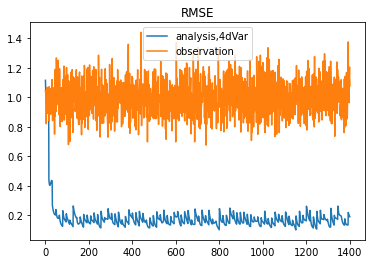

[0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 255, 272, 289, 306, 323, 340, 357, 374, 391, 408, 425, 442, 459, 476, 493, 510, 527, 544, 561, 578, 595, 612, 629, 646, 663, 680, 697, 714, 731, 748, 765, 782, 799, 816, 833, 850, 867, 884, 901, 918, 935, 952, 969, 986, 1003, 1020, 1037, 1054, 1071, 1088, 1105, 1122, 1139, 1156, 1173, 1190, 1207, 1224, 1241, 1258, 1275, 1292, 1309, 1326, 1343, 1360, 1377, 1394]
(17, 40)
17 17
296 end
0
(17, 40)
17 17
290 end
17
(17, 40)
17 17
266 end
34
(17, 40)
17 17
277 end
51
(17, 40)
17 17
265 end
68
(17, 40)
17 17
287 end
85
(17, 40)
17 17
272 end
102
(17, 40)
17 17
277 end
119
(17, 40)
17 17
258 end
136
(17, 40)
17 17
272 end
153
(17, 40)
17 17
271 end
170
(17, 40)
17 17
272 end
187
(17, 40)
17 17
280 end
204
(17, 40)
17 17
294 end
221
(17, 40)
17 17
254 end
238
(17, 40)
17 17
282 end
255
(17, 40)
17 17
274 end
272
(17, 40)
17 17
262 end
289
(17, 40)
17 17
269 end
306
(17, 40)
17 17
257 end
323
(17, 40)
17 17
274 end
340
(17, 40

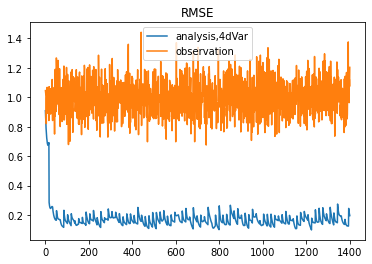

[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270, 288, 306, 324, 342, 360, 378, 396, 414, 432, 450, 468, 486, 504, 522, 540, 558, 576, 594, 612, 630, 648, 666, 684, 702, 720, 738, 756, 774, 792, 810, 828, 846, 864, 882, 900, 918, 936, 954, 972, 990, 1008, 1026, 1044, 1062, 1080, 1098, 1116, 1134, 1152, 1170, 1188, 1206, 1224, 1242, 1260, 1278, 1296, 1314, 1332, 1350, 1368, 1386]
(18, 40)
18 18
268 end
0
(18, 40)
18 18
274 end
18
(18, 40)
18 18
262 end
36
(18, 40)
18 18
270 end
54
(18, 40)
18 18
268 end
72
(18, 40)
18 18
285 end
90
(18, 40)
18 18
257 end
108
(18, 40)
18 18
275 end
126
(18, 40)
18 18
268 end
144
(18, 40)
18 18
270 end
162
(18, 40)
18 18
274 end
180
(18, 40)
18 18
274 end
198
(18, 40)
18 18
273 end
216
(18, 40)
18 18
276 end
234
(18, 40)
18 18
292 end
252
(18, 40)
18 18
270 end
270
(18, 40)
18 18
259 end
288
(18, 40)
18 18
266 end
306
(18, 40)
18 18
259 end
324
(18, 40)
18 18
262 end
342
(18, 40)
18 18
286 end
360
(18, 40)
18 18
282 end
378
(18, 40

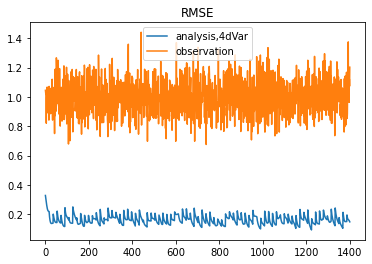

[0, 19, 38, 57, 76, 95, 114, 133, 152, 171, 190, 209, 228, 247, 266, 285, 304, 323, 342, 361, 380, 399, 418, 437, 456, 475, 494, 513, 532, 551, 570, 589, 608, 627, 646, 665, 684, 703, 722, 741, 760, 779, 798, 817, 836, 855, 874, 893, 912, 931, 950, 969, 988, 1007, 1026, 1045, 1064, 1083, 1102, 1121, 1140, 1159, 1178, 1197, 1216, 1235, 1254, 1273, 1292, 1311, 1330, 1349, 1368, 1387]
(19, 40)
19 19
287 end
0
(19, 40)
19 19
288 end
19
(19, 40)
19 19
302 end
38
(19, 40)
19 19
260 end
57
(19, 40)
19 19
275 end
76
(19, 40)
19 19
266 end
95
(19, 40)
19 19
262 end
114
(19, 40)
19 19
248 end
133
(19, 40)
19 19
271 end
152
(19, 40)
19 19
267 end
171
(19, 40)
19 19
273 end
190
(19, 40)
19 19
279 end
209
(19, 40)
19 19
280 end
228
(19, 40)
19 19
247 end
247
(19, 40)
19 19
269 end
266
(19, 40)
19 19
274 end
285
(19, 40)
19 19
274 end
304
(19, 40)
19 19
253 end
323
(19, 40)
19 19
261 end
342
(19, 40)
19 19
281 end
361
(19, 40)
19 19
280 end
380
(19, 40)
19 19
271 end
399
(19, 40)
19 19
256 end
418
(

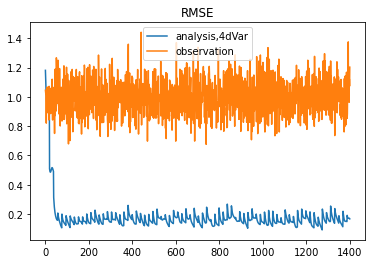

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380]
(20, 40)
20 20
281 end
0
(20, 40)
20 20
284 end
20
(20, 40)
20 20
285 end
40
(20, 40)
20 20
273 end
60
(20, 40)
20 20
277 end
80
(20, 40)
20 20
256 end
100
(20, 40)
20 20
281 end
120
(20, 40)
20 20
251 end
140
(20, 40)
20 20
261 end
160
(20, 40)
20 20
272 end
180
(20, 40)
20 20
274 end
200
(20, 40)
20 20
291 end
220
(20, 40)
20 20
274 end
240
(20, 40)
20 20
265 end
260
(20, 40)
20 20
262 end
280
(20, 40)
20 20
264 end
300
(20, 40)
20 20
265 end
320
(20, 40)
20 20
273 end
340
(20, 40)
20 20
286 end
360
(20, 40)
20 20
280 end
380
(20, 40)
20 20
274 end
400
(20, 40)
20 20
247 end
420
(20, 40)
20 20
267 end
440
(20, 40)
20 20
263 e

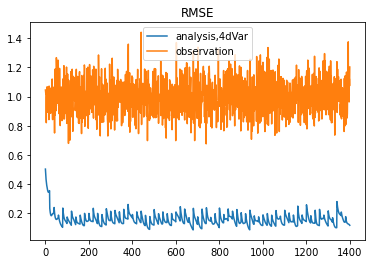

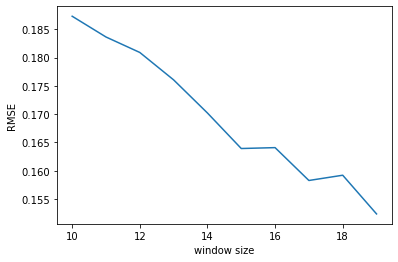

In [40]:
import time
t = 1400
N = 40
h = 0.05 
F = 2.0

dataset = pd.read_csv("observation_test.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("test.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
TLM=[]
A=[]
for i in range(10,20):
    #i=5
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = i

    Time=range(0,t,a_window+1)
    print(list(Time))
    
    for k in Time:
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        TLM.append(M)
        for l in range(a_window):
            Xb = Rungekutta4(Xa,h,F)
            X.append(Xb)
            Xa = Xb
        #if(k%100==0):
        print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    print(np.array(TLM).shape)

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

In [22]:
#4dVar with scipy.optimize
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    from scipy import optimize
    
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [] #TLM
    Mk = np.eye(N)
    M.append(Mk)
    MT = [] #ADM
    MkT = np.eye(N)
    MT.append(MkT)
    for k in range(a_window):
        xk = Fcst[k]
        Mk_ = np.eye(N)
        MkT_ = np.eye(N)
        #for l in range(N):
        #    e = E[l]
        #    Mk_[l] = Rungekutta4_t(xk,e,h,F)
        #    MkT_[l] = Rungekutta4_adj(e,xk,h,F)
        Mk_ = Rungekutta4_t(xk[:, None], E, h, F)
        MkT_ = Rungekutta4_adj(E, xk[:, None], h, F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    args=(U,R_inv,H,y,Fcst,M,MT,a_window)
    res = optimize.minimize(J, dv0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-6, 'disp':True})
    dv = res.x
    #dv = optimize.fmin_cg(J,dv0,fprime=jacobi,args=args)
    #dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,M,MT

def J(dv,*args):
    U,R_inv,H,y,Fcst,M,MT,a_window = args
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@U@dv-dk).T@R_inv@(H@Mk@U@dv-dk)/2
    return j+dv.T@dv/2

def jacobi(dv,*args):
    U,R_inv,H,y,Fcst,M,MT,a_window = args
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += U.T@MkT@H_t@R_inv@(H@Mk@U@dv-dk)
         
    return p+dv


[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192]
(16, 40)
16 16
Optimization terminated successfully.
         Current function value: 6999.460023
         Iterations: 33
         Function evaluations: 46
         Gradient evaluations: 46
0
(16, 40)
16 16
Optimization terminated successfully.
         Current function value: 6042.953687
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 50
16
(16, 40)
16 16
Optimization terminated successfully.
         Current function value: 5757.240739
         Iterations: 37
         Function evaluations: 50
         Gradient evaluations: 50
32
(16, 40)
16 16
Optimization terminated successfully.
         Current function value: 6588.153714
         Iterations: 36
         Function evaluations: 52
         Gradient evaluations: 52
48
(16, 40)
16 16
         Current function value: 6818.363257
         Iterations: 34
         Function evaluations: 52
         Gradient evaluations: 52
64
(16, 40)
16 16
O

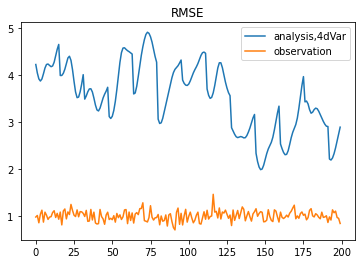

/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


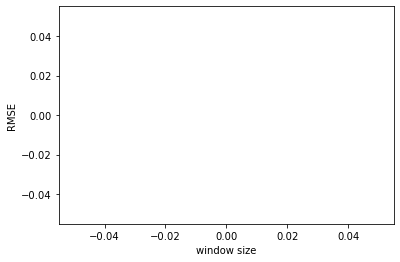

In [27]:
import time
t = 200
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
TLM=[]
A=[]
for i in range(1):
    i=15
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = i

    Time=range(0,t,a_window+1)
    print(list(Time))
    
    for k in Time:
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        TLM.append(M)
        for l in range(a_window):
            Xa = Rungekutta4(Xa,h,F)
            X.append(Xa)
        #if(k%100==0):
        print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    print(np.array(TLM).shape)

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

In [10]:
#4dVar with scipy.optimize (modified)

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    from scipy import optimize
    
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    #M = [] #TLM
    #Mk = np.eye(N)
    #M.append(Mk)
    #MT = [] #ADM
    #MkT = np.eye(N)
    #MT.append(MkT)
    #for k in range(a_window):
    #    xk = Fcst[k].reshape(-1,1)
    #    Mk_ = Rungekutta4_t(xk,E,h,F)
    #    MkT_ = Rungekutta4_adj(E,xk,h,F)
    #    Mk = Mk_@M[k]
    #    MkT = MT[k]@MkT_
    #    M.append(Mk)
    #    MT.append(MkT)
    #print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    args=(U,R_inv,H,y,Fcst,a_window)
    res = optimize.minimize(J, dv0, args=args, method='BFGS', jac=jacobi, options={'gtol':1e-6, 'disp':True})
    dv = res.x
    #dv = optimize.fmin_cg(J,dv0,fprime=jacobi,args=args)
    #dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa

def J(dv,*args):
    U,R_inv,H,y,Fcst,a_window = args
    xk = Fcst[0]
    yk = y[0]
    dk = yk-H@xk    
    dxk = U@dv
    j = (H@dxk-dk).T@R_inv@(H@dxk-dk)/2
    for k in range(1,a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mxk = Rungekutta4_t(Fcst[k-1],dxk,h,F)
        j += (H@Mxk-dk).T@R_inv@(H@Mxk-dk)/2
        dxk = Mxk
    return j+dv.T@dv/2

def jacobi(dv,*args):
    U,R_inv,H,y,Fcst,a_window = args
    
    #increment
    xk = Fcst[0]
    yk = y[0]
    dk = yk-H@xk
    dxk = U@dv
    dt = []
    dt.append(H.T@R_inv@(H@U@dxk-dk))
    for k in range(1,a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mxk = Rungekutta4_t(Fcst[k-1],dxk,h,F)
        dt.append(H.T@R_inv@(H@Mxk-dk))
        dxk = Mxk
        
    for k in range(a_window,0,-1):
        MkTx = Rungekutta4_adj(dt[k],Fcst[k-1],h,F)
        dt[k-1] += MkTx
    p = U.T@dt[0]
         
    return p+dv


[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656, 672, 688, 704, 720, 736, 752, 768, 784, 800, 816, 832, 848, 864, 880, 896, 912, 928, 944, 960, 976, 992, 1008, 1024, 1040, 1056, 1072, 1088, 1104, 1120, 1136, 1152, 1168, 1184, 1200, 1216, 1232, 1248, 1264, 1280, 1296, 1312, 1328, 1344, 1360, 1376, 1392]
(16, 40)
         Current function value: 4405.772168
         Iterations: 18
         Function evaluations: 122
         Gradient evaluations: 110
0
(16, 40)
         Current function value: 1733.709022
         Iterations: 20
         Function evaluations: 123
         Gradient evaluations: 111
1
(16, 40)
         Current function value: 783.965265
         Iterations: 19
         Function evaluations: 118
         Gradient evaluations: 106
2
(16, 40)
         Current function value: 451.717417
         Iterations: 21
         Functio

         Current function value: 275.942441
         Iterations: 20
         Function evaluations: 81
         Gradient evaluations: 70
36
(16, 40)
         Current function value: 278.628933
         Iterations: 24
         Function evaluations: 90
         Gradient evaluations: 78
37
(16, 40)
         Current function value: 278.381546
         Iterations: 23
         Function evaluations: 88
         Gradient evaluations: 76
38
(16, 40)
         Current function value: 281.578108
         Iterations: 21
         Function evaluations: 111
         Gradient evaluations: 99
39
(16, 40)
         Current function value: 278.059035
         Iterations: 24
         Function evaluations: 120
         Gradient evaluations: 108
40
(16, 40)
         Current function value: 275.459585
         Iterations: 24
         Function evaluations: 113
         Gradient evaluations: 101
41
(16, 40)
         Current function value: 285.082067
         Iterations: 19
         Function evaluations: 107
    

         Current function value: 299.298461
         Iterations: 23
         Function evaluations: 100
         Gradient evaluations: 88
74
(16, 40)
         Current function value: 294.914574
         Iterations: 21
         Function evaluations: 113
         Gradient evaluations: 101
75
(16, 40)
         Current function value: 278.459419
         Iterations: 22
         Function evaluations: 120
         Gradient evaluations: 108
76
(16, 40)
         Current function value: 263.166042
         Iterations: 27
         Function evaluations: 98
         Gradient evaluations: 87
77
(16, 40)
         Current function value: 264.043686
         Iterations: 17
         Function evaluations: 108
         Gradient evaluations: 96
78
(16, 40)
         Current function value: 261.699521
         Iterations: 23
         Function evaluations: 93
         Gradient evaluations: 81
79
(16, 40)
         Current function value: 271.652885
         Iterations: 24
         Function evaluations: 111
   

         Current function value: 308.217272
         Iterations: 18
         Function evaluations: 86
         Gradient evaluations: 74
112
(16, 40)
         Current function value: 302.930439
         Iterations: 21
         Function evaluations: 109
         Gradient evaluations: 97
113
(16, 40)
         Current function value: 311.435825
         Iterations: 18
         Function evaluations: 77
         Gradient evaluations: 65
114
(16, 40)
         Current function value: 308.907855
         Iterations: 17
         Function evaluations: 66
         Gradient evaluations: 55
115
(16, 40)
         Current function value: 307.241915
         Iterations: 21
         Function evaluations: 98
         Gradient evaluations: 86
116
(16, 40)
         Current function value: 314.078613
         Iterations: 17
         Function evaluations: 68
         Gradient evaluations: 58
117
(16, 40)
         Current function value: 308.122248
         Iterations: 18
         Function evaluations: 100
  

         Current function value: 326.809148
         Iterations: 18
         Function evaluations: 98
         Gradient evaluations: 86
150
(16, 40)
         Current function value: 326.704999
         Iterations: 27
         Function evaluations: 110
         Gradient evaluations: 98
151
(16, 40)
         Current function value: 318.518230
         Iterations: 17
         Function evaluations: 133
         Gradient evaluations: 121
152
(16, 40)
         Current function value: 315.902045
         Iterations: 19
         Function evaluations: 103
         Gradient evaluations: 91
153
(16, 40)
         Current function value: 310.963718
         Iterations: 28
         Function evaluations: 95
         Gradient evaluations: 84
154
(16, 40)
         Current function value: 305.674805
         Iterations: 19
         Function evaluations: 108
         Gradient evaluations: 96
155
(16, 40)
         Current function value: 306.418669
         Iterations: 26
         Function evaluations: 10

         Current function value: 271.259193
         Iterations: 21
         Function evaluations: 116
         Gradient evaluations: 104
188
(16, 40)
         Current function value: 282.459859
         Iterations: 21
         Function evaluations: 113
         Gradient evaluations: 101
189
(16, 40)
         Current function value: 279.711377
         Iterations: 22
         Function evaluations: 110
         Gradient evaluations: 98
190
(16, 40)
         Current function value: 283.137989
         Iterations: 26
         Function evaluations: 96
         Gradient evaluations: 84
191
(16, 40)
         Current function value: 286.778084
         Iterations: 19
         Function evaluations: 110
         Gradient evaluations: 98
192
(16, 40)
         Current function value: 288.004821
         Iterations: 22
         Function evaluations: 108
         Gradient evaluations: 96
193
(16, 40)
         Current function value: 292.106341
         Iterations: 21
         Function evaluations: 

         Current function value: 271.838652
         Iterations: 23
         Function evaluations: 83
         Gradient evaluations: 72
226
(16, 40)
         Current function value: 279.624168
         Iterations: 23
         Function evaluations: 110
         Gradient evaluations: 98
227
(16, 40)
         Current function value: 287.778436
         Iterations: 18
         Function evaluations: 109
         Gradient evaluations: 97
228
(16, 40)
         Current function value: 288.303145
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 108
229
(16, 40)
         Current function value: 293.242995
         Iterations: 24
         Function evaluations: 111
         Gradient evaluations: 99
230
(16, 40)
         Current function value: 286.237628
         Iterations: 24
         Function evaluations: 112
         Gradient evaluations: 100
231
(16, 40)
         Current function value: 294.871573
         Iterations: 19
         Function evaluations: 

         Current function value: 304.466645
         Iterations: 16
         Function evaluations: 124
         Gradient evaluations: 112
264
(16, 40)
         Current function value: 301.413503
         Iterations: 17
         Function evaluations: 107
         Gradient evaluations: 95
265
(16, 40)
         Current function value: 289.023475
         Iterations: 27
         Function evaluations: 125
         Gradient evaluations: 113
266
(16, 40)
         Current function value: 294.207145
         Iterations: 19
         Function evaluations: 86
         Gradient evaluations: 74
267
(16, 40)
         Current function value: 287.446419
         Iterations: 19
         Function evaluations: 110
         Gradient evaluations: 98
268
(16, 40)
         Current function value: 281.357668
         Iterations: 26
         Function evaluations: 83
         Gradient evaluations: 71
269
(16, 40)
         Current function value: 272.885682
         Iterations: 19
         Function evaluations: 1

         Current function value: 311.863205
         Iterations: 18
         Function evaluations: 101
         Gradient evaluations: 89
302
(16, 40)
         Current function value: 309.135092
         Iterations: 19
         Function evaluations: 108
         Gradient evaluations: 96
303
(16, 40)
         Current function value: 311.415892
         Iterations: 22
         Function evaluations: 120
         Gradient evaluations: 108
304
(16, 40)
         Current function value: 307.816472
         Iterations: 25
         Function evaluations: 106
         Gradient evaluations: 94
305
(16, 40)
         Current function value: 315.649837
         Iterations: 22
         Function evaluations: 96
         Gradient evaluations: 84
306
(16, 40)
         Current function value: 321.779726
         Iterations: 22
         Function evaluations: 101
         Gradient evaluations: 89
307
(16, 40)
         Current function value: 315.442883
         Iterations: 27
         Function evaluations: 9

         Current function value: 293.252792
         Iterations: 18
         Function evaluations: 60
         Gradient evaluations: 49
340
(16, 40)
         Current function value: 284.488298
         Iterations: 16
         Function evaluations: 82
         Gradient evaluations: 70
341
(16, 40)
         Current function value: 274.988095
         Iterations: 16
         Function evaluations: 76
         Gradient evaluations: 65
342
(16, 40)
         Current function value: 284.669822
         Iterations: 22
         Function evaluations: 104
         Gradient evaluations: 92
343
(16, 40)
         Current function value: 287.169153
         Iterations: 22
         Function evaluations: 107
         Gradient evaluations: 95
344
(16, 40)
         Current function value: 282.871592
         Iterations: 19
         Function evaluations: 113
         Gradient evaluations: 101
345
(16, 40)
         Current function value: 277.893165
         Iterations: 24
         Function evaluations: 99


         Current function value: 301.916623
         Iterations: 22
         Function evaluations: 90
         Gradient evaluations: 78
378
(16, 40)
         Current function value: 294.291766
         Iterations: 19
         Function evaluations: 76
         Gradient evaluations: 64
379
(16, 40)
         Current function value: 303.196649
         Iterations: 22
         Function evaluations: 110
         Gradient evaluations: 98
380
(16, 40)
         Current function value: 302.566623
         Iterations: 17
         Function evaluations: 107
         Gradient evaluations: 95
381
(16, 40)
         Current function value: 291.104548
         Iterations: 22
         Function evaluations: 110
         Gradient evaluations: 98
382
(16, 40)
         Current function value: 298.216911
         Iterations: 18
         Function evaluations: 85
         Gradient evaluations: 73
383
(16, 40)
         Current function value: 309.773055
         Iterations: 24
         Function evaluations: 116


         Current function value: 360.821822
         Iterations: 21
         Function evaluations: 94
         Gradient evaluations: 82
416
(16, 40)
         Current function value: 349.083502
         Iterations: 22
         Function evaluations: 87
         Gradient evaluations: 75
417
(16, 40)
         Current function value: 352.726760
         Iterations: 23
         Function evaluations: 100
         Gradient evaluations: 88
418
(16, 40)
         Current function value: 344.891128
         Iterations: 19
         Function evaluations: 102
         Gradient evaluations: 90
419
(16, 40)
         Current function value: 344.160240
         Iterations: 26
         Function evaluations: 103
         Gradient evaluations: 91
420
(16, 40)
         Current function value: 335.501953
         Iterations: 16
         Function evaluations: 117
         Gradient evaluations: 105
421
(16, 40)
         Current function value: 335.911847
         Iterations: 22
         Function evaluations: 83

         Current function value: 288.979249
         Iterations: 16
         Function evaluations: 100
         Gradient evaluations: 88
454
(16, 40)
         Current function value: 282.701965
         Iterations: 23
         Function evaluations: 98
         Gradient evaluations: 86
455
(16, 40)
         Current function value: 274.321335
         Iterations: 16
         Function evaluations: 93
         Gradient evaluations: 81
456
(16, 40)
         Current function value: 281.331210
         Iterations: 21
         Function evaluations: 95
         Gradient evaluations: 84
457
(16, 40)
         Current function value: 279.113241
         Iterations: 21
         Function evaluations: 79
         Gradient evaluations: 68
458
(16, 40)
         Current function value: 285.751821
         Iterations: 17
         Function evaluations: 96
         Gradient evaluations: 84
459
(16, 40)
         Current function value: 284.116250
         Iterations: 21
         Function evaluations: 103
  

         Current function value: 307.923503
         Iterations: 22
         Function evaluations: 109
         Gradient evaluations: 97
492
(16, 40)
         Current function value: 308.643930
         Iterations: 23
         Function evaluations: 100
         Gradient evaluations: 88
493
(16, 40)
         Current function value: 308.953274
         Iterations: 23
         Function evaluations: 101
         Gradient evaluations: 89
494
(16, 40)
         Current function value: 289.201709
         Iterations: 23
         Function evaluations: 110
         Gradient evaluations: 98
495
(16, 40)
         Current function value: 291.419717
         Iterations: 18
         Function evaluations: 115
         Gradient evaluations: 103
496
(16, 40)
         Current function value: 287.535663
         Iterations: 19
         Function evaluations: 107
         Gradient evaluations: 95
497
(16, 40)
         Current function value: 287.291823
         Iterations: 20
         Function evaluations: 

         Current function value: 296.865711
         Iterations: 25
         Function evaluations: 104
         Gradient evaluations: 92
530
(16, 40)
         Current function value: 291.146649
         Iterations: 24
         Function evaluations: 104
         Gradient evaluations: 92
531
(16, 40)
         Current function value: 288.668177
         Iterations: 17
         Function evaluations: 96
         Gradient evaluations: 84
532
(16, 40)
         Current function value: 281.871956
         Iterations: 23
         Function evaluations: 114
         Gradient evaluations: 102
533
(16, 40)
         Current function value: 271.529723
         Iterations: 21
         Function evaluations: 89
         Gradient evaluations: 77
534
(16, 40)
         Current function value: 270.989239
         Iterations: 26
         Function evaluations: 109
         Gradient evaluations: 97
535
(16, 40)
         Current function value: 272.153948
         Iterations: 23
         Function evaluations: 90

         Current function value: 324.531790
         Iterations: 23
         Function evaluations: 105
         Gradient evaluations: 93
568
(16, 40)
         Current function value: 318.662787
         Iterations: 17
         Function evaluations: 109
         Gradient evaluations: 97
569
(16, 40)
         Current function value: 313.234206
         Iterations: 27
         Function evaluations: 100
         Gradient evaluations: 88
570
(16, 40)
         Current function value: 308.376584
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 98
571
(16, 40)
         Current function value: 293.266622
         Iterations: 22
         Function evaluations: 111
         Gradient evaluations: 99
572
(16, 40)
         Current function value: 300.201151
         Iterations: 20
         Function evaluations: 77
         Gradient evaluations: 66
573
(16, 40)
         Current function value: 304.671301
         Iterations: 24
         Function evaluations: 93

         Current function value: 309.945122
         Iterations: 20
         Function evaluations: 115
         Gradient evaluations: 103
606
(16, 40)
         Current function value: 313.295376
         Iterations: 23
         Function evaluations: 133
         Gradient evaluations: 121
607
(16, 40)
         Current function value: 306.221064
         Iterations: 22
         Function evaluations: 66
         Gradient evaluations: 56
608
(16, 40)
         Current function value: 310.194021
         Iterations: 25
         Function evaluations: 105
         Gradient evaluations: 93
609
(16, 40)
         Current function value: 309.523084
         Iterations: 16
         Function evaluations: 119
         Gradient evaluations: 107
610
(16, 40)
         Current function value: 308.256082
         Iterations: 23
         Function evaluations: 113
         Gradient evaluations: 101
611
(16, 40)
         Current function value: 316.090756
         Iterations: 23
         Function evaluations

         Current function value: 314.406812
         Iterations: 20
         Function evaluations: 86
         Gradient evaluations: 74
644
(16, 40)
         Current function value: 304.093158
         Iterations: 20
         Function evaluations: 109
         Gradient evaluations: 97
645
(16, 40)
         Current function value: 297.172319
         Iterations: 23
         Function evaluations: 75
         Gradient evaluations: 65
646
(16, 40)
         Current function value: 285.964682
         Iterations: 19
         Function evaluations: 105
         Gradient evaluations: 93
647
(16, 40)
         Current function value: 289.884257
         Iterations: 22
         Function evaluations: 91
         Gradient evaluations: 79
648
(16, 40)
         Current function value: 286.709296
         Iterations: 24
         Function evaluations: 91
         Gradient evaluations: 80
649
(16, 40)
         Current function value: 283.716737
         Iterations: 22
         Function evaluations: 86
  

         Current function value: 278.389844
         Iterations: 18
         Function evaluations: 120
         Gradient evaluations: 108
682
(16, 40)
         Current function value: 273.739099
         Iterations: 23
         Function evaluations: 110
         Gradient evaluations: 98
683
(16, 40)
         Current function value: 270.705336
         Iterations: 20
         Function evaluations: 107
         Gradient evaluations: 95
684
(16, 40)
         Current function value: 280.349473
         Iterations: 19
         Function evaluations: 109
         Gradient evaluations: 97
685
(16, 40)
         Current function value: 285.716319
         Iterations: 19
         Function evaluations: 102
         Gradient evaluations: 90
686
(16, 40)
         Current function value: 287.562222
         Iterations: 22
         Function evaluations: 100
         Gradient evaluations: 88
687
(16, 40)
         Current function value: 273.001360
         Iterations: 22
         Function evaluations: 

         Current function value: 302.499713
         Iterations: 23
         Function evaluations: 98
         Gradient evaluations: 86
720
(16, 40)
         Current function value: 311.694954
         Iterations: 22
         Function evaluations: 101
         Gradient evaluations: 89
721
(16, 40)
         Current function value: 310.036877
         Iterations: 22
         Function evaluations: 114
         Gradient evaluations: 102
722
(16, 40)
         Current function value: 323.563097
         Iterations: 20
         Function evaluations: 107
         Gradient evaluations: 95
723
(16, 40)
         Current function value: 328.978789
         Iterations: 21
         Function evaluations: 109
         Gradient evaluations: 97
724
(16, 40)
         Current function value: 331.691777
         Iterations: 20
         Function evaluations: 111
         Gradient evaluations: 99
725
(16, 40)
         Current function value: 330.606038
         Iterations: 18
         Function evaluations: 9

         Current function value: 296.600304
         Iterations: 27
         Function evaluations: 100
         Gradient evaluations: 88
758
(16, 40)
         Current function value: 290.549532
         Iterations: 23
         Function evaluations: 65
         Gradient evaluations: 54
759
(16, 40)
         Current function value: 281.019070
         Iterations: 22
         Function evaluations: 85
         Gradient evaluations: 74
760
(16, 40)
         Current function value: 273.251696
         Iterations: 20
         Function evaluations: 99
         Gradient evaluations: 87
761
(16, 40)
         Current function value: 264.804983
         Iterations: 24
         Function evaluations: 76
         Gradient evaluations: 64
762
(16, 40)
         Current function value: 265.207126
         Iterations: 20
         Function evaluations: 76
         Gradient evaluations: 64
763
(16, 40)
         Current function value: 269.799334
         Iterations: 23
         Function evaluations: 103
  

         Current function value: 293.946092
         Iterations: 17
         Function evaluations: 124
         Gradient evaluations: 112
796
(16, 40)
         Current function value: 287.413774
         Iterations: 18
         Function evaluations: 103
         Gradient evaluations: 91
797
(16, 40)
         Current function value: 291.477157
         Iterations: 22
         Function evaluations: 79
         Gradient evaluations: 69
798
(16, 40)
         Current function value: 308.075349
         Iterations: 23
         Function evaluations: 102
         Gradient evaluations: 91
799
(16, 40)
         Current function value: 305.382481
         Iterations: 24
         Function evaluations: 107
         Gradient evaluations: 96
800
(16, 40)
         Current function value: 309.753890
         Iterations: 24
         Function evaluations: 85
         Gradient evaluations: 73
801
(16, 40)
         Current function value: 304.163064
         Iterations: 24
         Function evaluations: 10

         Current function value: 260.426081
         Iterations: 21
         Function evaluations: 108
         Gradient evaluations: 96
834
(16, 40)
         Current function value: 261.950596
         Iterations: 21
         Function evaluations: 104
         Gradient evaluations: 92
835
(16, 40)
         Current function value: 262.288162
         Iterations: 19
         Function evaluations: 81
         Gradient evaluations: 69
836
(16, 40)
         Current function value: 254.131781
         Iterations: 24
         Function evaluations: 84
         Gradient evaluations: 72
837
(16, 40)
         Current function value: 264.139722
         Iterations: 24
         Function evaluations: 116
         Gradient evaluations: 104
838
(16, 40)
         Current function value: 267.966603
         Iterations: 24
         Function evaluations: 91
         Gradient evaluations: 79
839
(16, 40)
         Current function value: 272.142446
         Iterations: 23
         Function evaluations: 102

         Current function value: 314.182313
         Iterations: 18
         Function evaluations: 99
         Gradient evaluations: 87
872
(16, 40)
         Current function value: 321.950941
         Iterations: 20
         Function evaluations: 74
         Gradient evaluations: 63
873
(16, 40)
         Current function value: 322.591053
         Iterations: 21
         Function evaluations: 113
         Gradient evaluations: 101
874
(16, 40)
         Current function value: 319.116540
         Iterations: 25
         Function evaluations: 99
         Gradient evaluations: 87
875
(16, 40)
         Current function value: 325.086248
         Iterations: 25
         Function evaluations: 121
         Gradient evaluations: 109
876
(16, 40)
         Current function value: 328.696080
         Iterations: 25
         Function evaluations: 113
         Gradient evaluations: 101
877
(16, 40)
         Current function value: 319.174124
         Iterations: 19
         Function evaluations: 1

         Current function value: 289.273345
         Iterations: 24
         Function evaluations: 94
         Gradient evaluations: 82
910
(16, 40)
         Current function value: 286.848548
         Iterations: 20
         Function evaluations: 104
         Gradient evaluations: 92
911
(16, 40)
         Current function value: 267.646575
         Iterations: 19
         Function evaluations: 118
         Gradient evaluations: 106
912
(16, 40)
         Current function value: 267.007815
         Iterations: 21
         Function evaluations: 68
         Gradient evaluations: 57
913
(16, 40)
         Current function value: 269.174163
         Iterations: 20
         Function evaluations: 73
         Gradient evaluations: 62
914
(16, 40)
         Current function value: 272.228684
         Iterations: 19
         Function evaluations: 112
         Gradient evaluations: 100
915
(16, 40)
         Current function value: 271.979325
         Iterations: 19
         Function evaluations: 89

         Current function value: 314.387551
         Iterations: 18
         Function evaluations: 87
         Gradient evaluations: 75
948
(16, 40)
         Current function value: 309.101798
         Iterations: 22
         Function evaluations: 112
         Gradient evaluations: 100
949
(16, 40)
         Current function value: 309.274416
         Iterations: 22
         Function evaluations: 111
         Gradient evaluations: 99
950
(16, 40)
         Current function value: 311.477115
         Iterations: 22
         Function evaluations: 98
         Gradient evaluations: 86
951
(16, 40)
         Current function value: 305.686315
         Iterations: 21
         Function evaluations: 113
         Gradient evaluations: 101
952
(16, 40)
         Current function value: 296.423014
         Iterations: 23
         Function evaluations: 105
         Gradient evaluations: 93
953
(16, 40)
         Current function value: 285.484386
         Iterations: 22
         Function evaluations: 1

         Current function value: 303.745354
         Iterations: 19
         Function evaluations: 98
         Gradient evaluations: 86
986
(16, 40)
         Current function value: 306.351204
         Iterations: 18
         Function evaluations: 103
         Gradient evaluations: 91
987
(16, 40)
         Current function value: 315.919976
         Iterations: 20
         Function evaluations: 113
         Gradient evaluations: 101
988
(16, 40)
         Current function value: 313.696666
         Iterations: 24
         Function evaluations: 117
         Gradient evaluations: 105
989
(16, 40)
         Current function value: 310.619131
         Iterations: 24
         Function evaluations: 117
         Gradient evaluations: 105
990
(16, 40)
         Current function value: 300.560988
         Iterations: 26
         Function evaluations: 97
         Gradient evaluations: 85
991
(16, 40)
         Current function value: 294.185940
         Iterations: 26
         Function evaluations: 

         Current function value: 293.755024
         Iterations: 18
         Function evaluations: 97
         Gradient evaluations: 85
1023
(16, 40)
         Current function value: 304.663412
         Iterations: 19
         Function evaluations: 112
         Gradient evaluations: 100
1024
(16, 40)
         Current function value: 296.137080
         Iterations: 23
         Function evaluations: 91
         Gradient evaluations: 80
1025
(16, 40)
         Current function value: 291.227150
         Iterations: 19
         Function evaluations: 115
         Gradient evaluations: 103
1026
(16, 40)
         Current function value: 287.951749
         Iterations: 24
         Function evaluations: 100
         Gradient evaluations: 88
1027
(16, 40)
         Current function value: 293.686096
         Iterations: 22
         Function evaluations: 85
         Gradient evaluations: 73
1028
(16, 40)
         Current function value: 296.132587
         Iterations: 23
         Function evaluatio

         Current function value: 355.969769
         Iterations: 22
         Function evaluations: 105
         Gradient evaluations: 93
1060
(16, 40)
         Current function value: 356.818413
         Iterations: 23
         Function evaluations: 131
         Gradient evaluations: 119
1061
(16, 40)
         Current function value: 353.180517
         Iterations: 19
         Function evaluations: 75
         Gradient evaluations: 64
1062
(16, 40)
         Current function value: 339.572939
         Iterations: 19
         Function evaluations: 116
         Gradient evaluations: 104
1063
(16, 40)
         Current function value: 335.710034
         Iterations: 18
         Function evaluations: 77
         Gradient evaluations: 65
1064
(16, 40)
         Current function value: 327.708125
         Iterations: 22
         Function evaluations: 100
         Gradient evaluations: 88
1065
(16, 40)
         Current function value: 312.620955
         Iterations: 17
         Function evaluati

         Current function value: 304.618748
         Iterations: 24
         Function evaluations: 118
         Gradient evaluations: 107
1097
(16, 40)
         Current function value: 309.456560
         Iterations: 19
         Function evaluations: 107
         Gradient evaluations: 95
1098
(16, 40)
         Current function value: 315.299982
         Iterations: 24
         Function evaluations: 114
         Gradient evaluations: 102
1099
(16, 40)
         Current function value: 312.838616
         Iterations: 18
         Function evaluations: 90
         Gradient evaluations: 78
1100
(16, 40)
         Current function value: 314.706375
         Iterations: 18
         Function evaluations: 66
         Gradient evaluations: 55
1101
(16, 40)
         Current function value: 316.401534
         Iterations: 19
         Function evaluations: 90
         Gradient evaluations: 78
1102
(16, 40)
         Current function value: 306.730745
         Iterations: 22
         Function evaluatio

         Current function value: 291.172015
         Iterations: 21
         Function evaluations: 97
         Gradient evaluations: 85
1134
(16, 40)
         Current function value: 306.292339
         Iterations: 21
         Function evaluations: 115
         Gradient evaluations: 103
1135
(16, 40)
         Current function value: 307.440593
         Iterations: 22
         Function evaluations: 90
         Gradient evaluations: 78
1136
(16, 40)
         Current function value: 297.164751
         Iterations: 18
         Function evaluations: 126
         Gradient evaluations: 114
1137
(16, 40)
         Current function value: 309.528552
         Iterations: 18
         Function evaluations: 67
         Gradient evaluations: 55
1138
(16, 40)
         Current function value: 300.180734
         Iterations: 16
         Function evaluations: 107
         Gradient evaluations: 95
1139
(16, 40)
         Current function value: 301.472565
         Iterations: 16
         Function evaluatio

         Current function value: 302.163188
         Iterations: 21
         Function evaluations: 113
         Gradient evaluations: 101
1171
(16, 40)
         Current function value: 298.070358
         Iterations: 17
         Function evaluations: 121
         Gradient evaluations: 109
1172
(16, 40)
         Current function value: 294.039462
         Iterations: 23
         Function evaluations: 105
         Gradient evaluations: 93
1173
(16, 40)
         Current function value: 292.118961
         Iterations: 18
         Function evaluations: 77
         Gradient evaluations: 66
1174
(16, 40)
         Current function value: 303.422974
         Iterations: 18
         Function evaluations: 99
         Gradient evaluations: 87
1175
(16, 40)
         Current function value: 298.083398
         Iterations: 23
         Function evaluations: 93
         Gradient evaluations: 82
1176
(16, 40)
         Current function value: 299.481894
         Iterations: 24
         Function evaluatio

         Current function value: 281.970655
         Iterations: 23
         Function evaluations: 112
         Gradient evaluations: 100
1208
(16, 40)
         Current function value: 288.762878
         Iterations: 24
         Function evaluations: 114
         Gradient evaluations: 102
1209
(16, 40)
         Current function value: 286.955954
         Iterations: 20
         Function evaluations: 97
         Gradient evaluations: 85
1210
(16, 40)
         Current function value: 288.251886
         Iterations: 18
         Function evaluations: 101
         Gradient evaluations: 89
1211
(16, 40)
Optimization terminated successfully.
         Current function value: 294.267701
         Iterations: 28
         Function evaluations: 47
         Gradient evaluations: 47
1212
(16, 40)
         Current function value: 296.157459
         Iterations: 25
         Function evaluations: 79
         Gradient evaluations: 67
1213
(16, 40)
         Current function value: 304.619253
         Iter

         Current function value: 302.704905
         Iterations: 19
         Function evaluations: 78
         Gradient evaluations: 68
1246
(16, 40)
         Current function value: 298.375671
         Iterations: 24
         Function evaluations: 148
         Gradient evaluations: 136
1247
(16, 40)
         Current function value: 310.651269
         Iterations: 23
         Function evaluations: 106
         Gradient evaluations: 94
1248
(16, 40)
         Current function value: 309.906758
         Iterations: 20
         Function evaluations: 95
         Gradient evaluations: 83
1249
(16, 40)
         Current function value: 317.510372
         Iterations: 21
         Function evaluations: 108
         Gradient evaluations: 96
1250
(16, 40)
         Current function value: 316.785361
         Iterations: 23
         Function evaluations: 107
         Gradient evaluations: 95
1251
(16, 40)
         Current function value: 320.492543
         Iterations: 19
         Function evaluatio

         Current function value: 305.299024
         Iterations: 16
         Function evaluations: 88
         Gradient evaluations: 77
1283
(16, 40)
         Current function value: 306.242692
         Iterations: 27
         Function evaluations: 85
         Gradient evaluations: 73
1284
(16, 40)
         Current function value: 303.955999
         Iterations: 20
         Function evaluations: 109
         Gradient evaluations: 97
1285
(16, 40)
         Current function value: 305.040814
         Iterations: 24
         Function evaluations: 105
         Gradient evaluations: 93
1286
(16, 40)
         Current function value: 307.437256
         Iterations: 23
         Function evaluations: 86
         Gradient evaluations: 74
1287
(16, 40)
         Current function value: 311.094998
         Iterations: 23
         Function evaluations: 106
         Gradient evaluations: 94
1288
(16, 40)
         Current function value: 312.225641
         Iterations: 23
         Function evaluations

         Current function value: 300.067531
         Iterations: 16
         Function evaluations: 111
         Gradient evaluations: 99
1320
(16, 40)
         Current function value: 289.767081
         Iterations: 18
         Function evaluations: 95
         Gradient evaluations: 83
1321
(16, 40)
         Current function value: 290.253664
         Iterations: 19
         Function evaluations: 103
         Gradient evaluations: 91
1322
(16, 40)
         Current function value: 284.699615
         Iterations: 22
         Function evaluations: 71
         Gradient evaluations: 60
1323
(16, 40)
         Current function value: 285.472703
         Iterations: 16
         Function evaluations: 116
         Gradient evaluations: 104
1324
(16, 40)
         Current function value: 284.582302
         Iterations: 22
         Function evaluations: 103
         Gradient evaluations: 91
1325
(16, 40)
         Current function value: 284.193374
         Iterations: 22
         Function evaluatio

         Current function value: 308.112661
         Iterations: 26
         Function evaluations: 106
         Gradient evaluations: 94
1357
(16, 40)
         Current function value: 316.169645
         Iterations: 22
         Function evaluations: 114
         Gradient evaluations: 102
1358
(16, 40)
         Current function value: 318.245389
         Iterations: 19
         Function evaluations: 115
         Gradient evaluations: 103
1359
(16, 40)
         Current function value: 317.025543
         Iterations: 23
         Function evaluations: 109
         Gradient evaluations: 97
1360
(16, 40)
         Current function value: 323.807556
         Iterations: 25
         Function evaluations: 76
         Gradient evaluations: 64
1361
(16, 40)
         Current function value: 316.612610
         Iterations: 18
         Function evaluations: 103
         Gradient evaluations: 91
1362
(16, 40)
         Current function value: 319.827807
         Iterations: 27
         Function evaluat

         Current function value: 317.821065
         Iterations: 23
         Function evaluations: 108
         Gradient evaluations: 96
1394
(16, 40)
         Current function value: 313.558148
         Iterations: 25
         Function evaluations: 99
         Gradient evaluations: 87
1395
(16, 40)
         Current function value: 308.730013
         Iterations: 19
         Function evaluations: 111
         Gradient evaluations: 99
1396
(16, 40)
         Current function value: 305.896644
         Iterations: 27
         Function evaluations: 111
         Gradient evaluations: 99
1397
(16, 40)
         Current function value: 307.911536
         Iterations: 24
         Function evaluations: 84
         Gradient evaluations: 72
1398
(16, 40)
         Current function value: 312.731543
         Iterations: 19
         Function evaluations: 81
         Gradient evaluations: 69
1399
elapsed_time:7962.966666460037[sec]


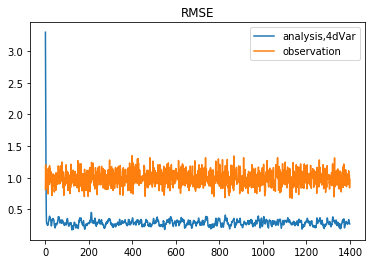

0.28770510130615673


In [16]:
import time
t = 1400
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
A=[]
for i in range(1):
    i=15
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = i

    Time=range(0,t,a_window+1)
    print(list(Time))
    
    for k in range(t):
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        Xa = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        #for l in range(a_window):
        #    Xb = Rungekutta4(Xa,h,F)
        #    X.append(Xb)
        #    Xa = Xb
        #if(k%100==0):
        print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    
    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    plt.savefig("4dVar_window"+str(a_window)+".png")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    print(r)
    RMSE.append(r)
    A.append(a_window)

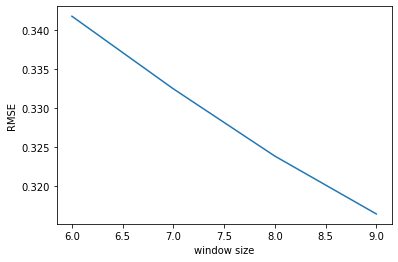

In [15]:
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

[[-0.2490739   0.26989896  0.50578661  0.97135867  0.81686492  0.40700197
   0.12760711  0.48990083  0.3026442   0.91075039  0.47250591  0.28259798
   0.07476412  0.04629482  0.2196689   0.92943035  0.37801589  0.12539999
   0.16927817  0.14645487  0.05246     0.38869726 -0.24413971  0.10531986
   0.75822953  0.65544506  0.61397899  0.1633552   0.14306171  0.96627184
   0.61604561 -0.03622691  0.04854172  0.77361565  0.76574603  0.27266244
   0.38581968  0.07764816  0.73006815  0.52939852]
 [-0.03401109  0.44370328  0.85666145  0.75606736  0.51148573  0.39344289
   0.15749347  0.57789142  0.86096394  0.93417832  0.59384009  0.12757904
  -0.00878752  0.35628189  0.8606473   0.75982662  0.23612793  0.10603619
   0.33481025  0.84024683  0.52519634  0.02445413  0.13365885  0.5961995
   0.6455037   0.37379898  0.32298819  0.37068961  0.48440491  1.18734592
   0.58382663 -0.09309223  0.03537159  0.57914341  0.82400864  0.37915709
   0.68164593  0.85703109  0.80149755  0.45298597]
 [ 0.027930

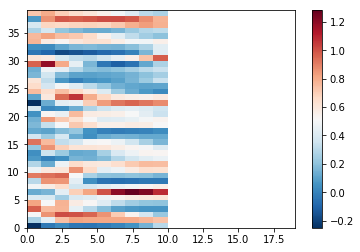

In [13]:
trM=[]
for k in range(len(TLM)):
    trM.append(np.diag(np.mean(np.array(TLM)[k,:,:,:], axis=0)))
diagM = np.array(trM).reshape(len(TLM),-1)
print(diagM[:])
ts = np.arange(len(TLM))
xs = np.arange(N)
plt.pcolor(ts,xs,diagM.T,cmap='RdBu_r')
plt.colorbar()
plt.show()

In [15]:
print(X[:20]-y[:20])

[[ 7.92929388e+000  5.08411804e+000 -3.69917445e+000  1.06605417e+000
  -3.70040006e+000 -7.50378332e-001  6.11758374e+000 -2.84203252e-001
  -9.13915904e+000 -1.42506114e-001  9.58548774e-001 -1.48447812e+000
  -9.68791380e-001  8.89850197e+000 -4.38426206e+000  1.54270243e-001
  -1.66187314e+000  9.99836845e-001  5.89353307e-001 -2.89402891e+000
  -5.23348204e+000 -2.58121618e+000  4.39086614e+000  2.81050916e-001
  -2.58228897e+000 -2.09639259e+000  2.21152265e+000 -6.95812266e-001
   7.87457388e-001  1.28535581e+000  3.34091384e+000 -4.71217255e+000
  -2.11744201e+000 -1.60977195e+000 -3.62984269e+000  3.31003768e-001
   4.59375098e+000 -3.90147845e+000 -5.57981328e+000 -8.31421063e-002]
 [ 3.98859971e+000  2.38944935e+000 -5.20232660e-001  5.01401429e-001
  -2.47400078e+000  2.28968530e+000  9.63690662e-001 -1.25998834e+000
  -4.84789237e+000 -3.59320582e+000  2.47873905e-001 -6.47094200e-001
   1.17511292e+000  3.38373669e+000 -5.86294155e+000  9.49111584e-001
   1.76846485e-002 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


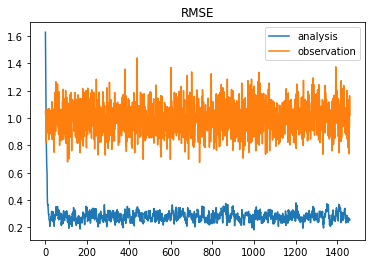

In [33]:
#Optimal Interpolation
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    
    Xf = Rungekutta4(Xa,h,F)
    #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    R = np.eye(N)
    I = np.eye(N)
    
    
    d = y - H @ Xf
    #d = y_ - H3(Xf,mask)
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(Pf)
    
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    
    #A = B_inv + H3adj @ R_inv @ H3t
    
    Xa = Xf + np.linalg.inv(B_inv + H.T @ R_inv @ H) @ H.T @ R_inv @ d
    #Xa = Xf + np.linalg.inv(A) @ H3adj @ R_inv @ d
    
    return Xa


t = 1460
N = 40
h = 0.05 
F = 2.0

X = []
P = []
Pt2 = []
P2 = []
errcov = []

dataset = pd.read_csv("observation_test.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("test.csv")
Xt = dataset2.values.reshape(t,N)

#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
B = np.eye(N) * 0.2
#B = L*0.2
#print(Xa)
#print(B)
#X.append(Xa
    


for k in range(t):
    (Xf,Pf) = Forecast(Xa,B)
    Xa = Analysis(Xf,Pf,y[k,:])
    X.append(Xa)
    if(k%100==0):
        print(k)
    
Xa = np.array(X)
#print(Xa)

C1 = []
C2 = []
H = np.eye(N)
H2 = H/2 + np.roll(H,1,axis=1)/2
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i]
    X3 = sum((X2-X1)*(X2-X1))/N
    Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    C1.append(rmse1)
    C2.append(rmse2)
plt.plot(C1,label="analysis")
plt.plot(C2,label="observation")
#plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE")
#plt.savefig("KFrmse2.jpg")
plt.show()

In [17]:
print(M)
print(MT)
print(np.linalg.norm(M[6]-MT[6].T))

[array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, 

In [22]:
#4dVar
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    a = 1.2
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [np.eye(N)] #TLM
    Mk = np.eye(N)
    MT = [np.eye(N)] #ADM
    MkT = np.eye(N)
    for k in range(a_window):
        xk = Fcst[k].reshape(-1,1)
        Mk_ = Rungekutta4_t(xk,E,h,F)
        MkT_ = Rungekutta4_adj(E,xk,h,F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    print(len(M),len(MT))
    
    #U = np.linalg.cholesky(B)
    dx0 = np.zeros(N)
    dx = CG(dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
    #X = U@dv
    Xa = dx + Xf
    
    return Xa,M,MT

def J(dx,B_inv,R_inv,H,y,Fcst,M,a_window):
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@dx-dk).T@R_inv@(H@Mk@dx-dk)/2
    return j+dx.T@B_inv@dx/2

def jacobi(dx,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += MkT@H_t@R_inv@(H@Mk@dx-dk)
         
    return p+B_inv@dx

def CG(dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    d0 = -jacobi(dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
    for k in range(1000):
        #alpha = golden_section(d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        alpha=0.01
        dx = dx0 + alpha*d0
        d = jacobi(dx,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        #err = np.sqrt(np.sum(d**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d**2))<0.001):
            print(k,"end")
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        dx0 = dx
        d0 = p
    return dx

def golden_section(d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    a0=1e-2
    b0=1
    t = (-1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=b-t*(b-a)
    c2=a+t*(b-a)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    while abs(b-a)/2>0.0001:
        num+=1
        f1 = fj(c1,d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        #dv1 = dv0 + c1*d0
        #f1 = J(dv1,U,R_inv,H,y,Fcst,M,a_window)
        f2 = fj(c2,d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window)
        #dv2 = dv0 + c2*d0
        #f2 = J(dv2,U,R_inv,H,y,Fcst,M,a_window)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=b-t*(b-a)
        else:
            a=c1
            b=b
            c1=c2
            c2=a+t*(b-a)
    alpha = (a+b)/2    
    #print(num,"end",alpha)
    return alpha

def fj(c,d0,dx0,B_inv,R_inv,H,y,Fcst,M,MT,a_window):
    dx = dx0 + c*d0
    return J(dx,B_inv,R_inv,H,y,Fcst,M,a_window)

In [ ]:
import time
t = 1460
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
A=[]
for i in range(1):
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    B = np.eye(N) * 0.2
    
    a_window = 10

    for k in range(t-a_window):
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        Xb=Xa
        for l in range(a_window):
            Xc = Rungekutta4(Xb,h,F)
            Xb = Xc
        X.append(Xb)
        if(k%100==0):
            print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t-a_window):
        X1 = X[i]
        X2 = Xt[i+a_window]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i+a_window]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+".jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize.jpg")
plt.show()

(11, 40)
11 11


C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in add


0
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)
11 11
(11, 40)

In [26]:
#4dVar with L-BFGS
import scipy.optimize as opt

def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    a = 1.0
    
    Xf = Rungekutta4(Xa,h,F)
   
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,B,y,a_window):
    H = np.eye(N)
    #H2 = H/2 + np.roll(H,1,axis=1)/2
    #mask = y>=0
    #y_ = y[mask]
    #e = np.ones(N)
    #p = int(np.sum(e[mask]))
    #R = np.eye(p)
    """Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)"""
    R = np.eye(N)
    E = np.eye(N)
    
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(B)
      
    Fcst = [] #基本場
    xb = Xf
    Fcst.append(xb)
    for k in range(a_window):
        Xf_ = Rungekutta4(xb,h,F)
        Fcst.append(Xf_)
        xb = Xf_
        
    M = [] #TLM
    Mk = np.eye(N)
    M.append(Mk)
    MT = [] #ADM
    MkT = np.eye(N)
    MT.append(MkT)
    for k in range(a_window):
        xk = Fcst[k].reshape(-1,1)
        Mk_ = Rungekutta4_t(xk,E,h,F)
        MkT_ = Rungekutta4_adj(E,xk,h,F)
        Mk = Mk_@M[k]
        MkT = MT[k]@MkT_
        M.append(Mk)
        MT.append(MkT)
    #print(len(M),len(MT))
    
    U = np.linalg.cholesky(B)
    dv0 = np.zeros(N)
    res = opt.minimize(J,dv0,args=(U,R_inv,H,y,Fcst,M,MT,a_window),
                       method='L-BFGS-B',jac=jacobi,
                       options={'disp':0,'maxiter':1000})
    dv = res.x
    #dv = CG(dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
    X = U@dv
    Xa = X + Xf
    
    return Xa,M,MT

def J(dv,U,R_inv,H,y,Fcst,M,MT,a_window):
    j = 0
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        j += (H@Mk@U@dv-dk).T@R_inv@(H@Mk@U@dv-dk)/2
    return j+dv.T@dv/2

def jacobi(dv,U,R_inv,H,y,Fcst,M,MT,a_window):
    H_t = H.T
    
    p = np.zeros(N)
    for k in range(a_window+1):
        xk = Fcst[k]
        yk = y[k]
        dk = yk-H@xk
        Mk = M[k]
        MkT = MT[k]
        p += U.T@MkT@H_t@R_inv@(H@Mk@U@dv-dk)
         
    return p+dv


0
elapsed_time:29.496246337890625[sec]


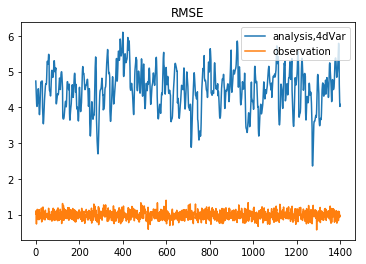

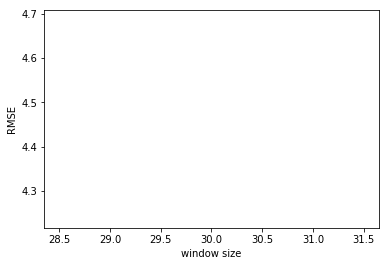

In [28]:
import time
t = 1400
N = 40
h = 0.05 
F = 8.0

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(1460,N)

#print(Xa)
#print(B)
#X.append(Xa
RMSE=[]
A=[]
for i in range(1):
    start = time.time()
    X = []

    #初期値
    Xa = np.random.randn(N)
    X0 = Xa
    for j in range(500):
        Xa = Rungekutta4(X0,h,F)
        X0 = Xa
    #X.append(Xa)
    
    B = np.eye(N) * 0.2
    
    a_window = 30

    Time=range(0,t,a_window+1)
    #print(list(Time))
    
    for k in Time:
        (Xf,B) = Forecast(Xa,B)
        obs = y[k:k+a_window+1,:]
        #print(obs.shape)
        (Xa,M,MT) = Analysis(Xf,B,obs,a_window)
        X.append(Xa)
        for l in range(a_window):
            Xb = Rungekutta4(Xa,h,F)
            X.append(Xb)
            Xa = Xb
        if(k%100==0):
            print(k)

    elapsed_time = time.time()-start
    print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    #XA = np.array(X)
#print(Xa)

    C1_ = []
    C2_ = []
    H = np.eye(N)
#H2 = H/2 + np.roll(H,1,axis=1)/2
    for i in range(t):
        X1 = X[i]
        X2 = Xt[i]
        X3 = sum((X2-X1)*(X2-X1))/N
        Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
        Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
        rmse1 = np.sqrt(X3)
        rmse2 = np.sqrt(Y2)
        C1_.append(rmse1)
        C2_.append(rmse2)
    #plt.plot(C1,label="analysis,OI")
    plt.plot(C1_,label="analysis,4dVar")
    plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
    plt.legend()
    plt.title("RMSE")
    #plt.savefig("4dVar_window"+str(a_window)+"2.jpg")
    plt.show()
    
    r=np.mean(np.array(C1_[500:]))
    RMSE.append(r)
    A.append(a_window)
    
plt.plot(A,RMSE)
plt.xlabel("window size")
plt.ylabel("RMSE")
#plt.savefig("4dVar_windowsize2.jpg")
plt.show()

In [19]:
X=[]
a_window=10
for k in range(0,t,a_window):
    X.append(k)
print(X)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450]


[[1.00000000e+00 5.00000000e-01 2.50000000e-01 ... 6.31088724e-30
  3.15544362e-30 1.57772181e-30]
 [5.00000000e-01 1.00000000e+00 5.00000000e-01 ... 1.26217745e-29
  6.31088724e-30 3.15544362e-30]
 [2.50000000e-01 5.00000000e-01 1.00000000e+00 ... 2.52435490e-29
  1.26217745e-29 6.31088724e-30]
 ...
 [6.31088724e-30 1.26217745e-29 2.52435490e-29 ... 1.00000000e+00
  5.00000000e-01 2.50000000e-01]
 [3.15544362e-30 6.31088724e-30 1.26217745e-29 ... 5.00000000e-01
  1.00000000e+00 5.00000000e-01]
 [1.57772181e-30 3.15544362e-30 6.31088724e-30 ... 2.50000000e-01
  5.00000000e-01 1.00000000e+00]] [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  9

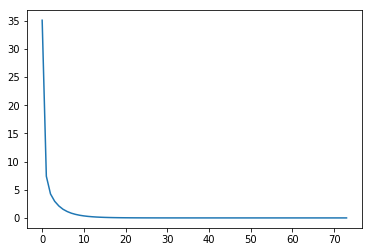

[ 1.          2.          3.          4.          5.          6.
  7.          8.          9.         10.         11.         12.
 13.         14.         15.         16.         17.         18.
 19.         20.         21.         22.         23.         24.
 25.         26.00000001 27.00000001 28.00000001 29.00000001 30.00000001
 31.00000001 32.00000001 33.00000001 34.00000001 35.00000001 36.00000001
 37.00000001 38.00000001 39.00000001 40.00000001 41.00000001 42.00000001
 43.00000001 44.00000001 45.00000001 46.00000001 47.00000001 48.00000001
 49.00000001 50.00000001 51.00000001 52.00000001 53.00000001 54.00000001
 55.00000001 56.00000001 57.00000001 58.00000001 59.00000001 60.00000001
 61.00000001 62.00000001 63.00000001 64.00000001 65.00000001 66.00000001
 67.00000001 68.00000001 69.00000001 70.00000001 71.00000001 72.00000001
 73.00000001 74.00000001 75.00000001 76.00000001 77.00000001 78.00000001
 79.00000001 80.00000001 81.00000001 82.         83.         84.
 85.         86.  

In [42]:
#Gradient descent
N = 100
A = np.ones((N,N))
for i in range(N):
    for j in range(i+1,N):
        A[i,j]=A[i,j]/2**(j-i)
for i in range(N):
    for j in range(i):
        A[i,j]=A[j,i]
b = np.arange(1,N+1)
print(A,b)
E=[]
x0 = b
r = b - A@x0
p = r
for k in range(10000):
    a = np.dot(p,r)/np.dot(p,A@p)
    x = x0 + a*p
    r = b - A@x
    p = r
    x0 = x
    #print(a,x,r)
    err = np.sqrt(np.dot(r,r))
    E.append(err)
    if(err<1e-7):
        print(k,x)
        break
plt.plot(E)
plt.show()
print(A@x)

[[1.00000000e+00 2.50000000e-01 6.25000000e-02 1.56250000e-02
  3.90625000e-03 9.76562500e-04 2.44140625e-04 6.10351562e-05
  1.52587891e-05 3.81469727e-06 9.53674316e-07 2.38418579e-07
  5.96046448e-08 1.49011612e-08 3.72529030e-09 9.31322575e-10
  2.32830644e-10 5.82076609e-11 1.45519152e-11 3.63797881e-12]
 [2.50000000e-01 1.00000000e+00 2.50000000e-01 6.25000000e-02
  1.56250000e-02 3.90625000e-03 9.76562500e-04 2.44140625e-04
  6.10351562e-05 1.52587891e-05 3.81469727e-06 9.53674316e-07
  2.38418579e-07 5.96046448e-08 1.49011612e-08 3.72529030e-09
  9.31322575e-10 2.32830644e-10 5.82076609e-11 1.45519152e-11]
 [6.25000000e-02 2.50000000e-01 1.00000000e+00 2.50000000e-01
  6.25000000e-02 1.56250000e-02 3.90625000e-03 9.76562500e-04
  2.44140625e-04 6.10351562e-05 1.52587891e-05 3.81469727e-06
  9.53674316e-07 2.38418579e-07 5.96046448e-08 1.49011612e-08
  3.72529030e-09 9.31322575e-10 2.32830644e-10 5.82076609e-11]
 [1.56250000e-02 6.25000000e-02 2.50000000e-01 1.00000000e+00
  2.5

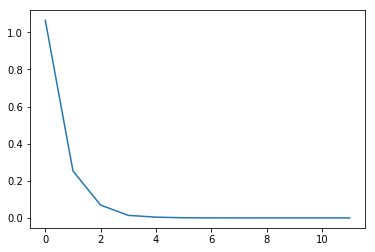

[ 3.32294923e-08  3.11145190e-08  2.19224949e-09 -2.94255895e-08
 -3.16895896e-08  2.41206521e-09  3.44425279e-08  1.29516797e-08
 -2.68196567e-08 -1.09143485e-08  2.90613187e-08 -3.34627508e-08
  3.00600007e-08 -3.79324661e-09 -8.07692935e-09 -7.82746135e-09
  5.19226973e-09  9.16450205e-09 -5.37664135e-10 -8.13333756e-09]


In [64]:
#Conjucate Gradient
N = 20
A = np.ones((N,N))
for i in range(N):
    for j in range(i+1,N):
        A[i,j]=A[i,j]/4**(j-i)
for i in range(N):
    for j in range(i):
        A[i,j]=A[j,i]
b = np.arange(N)
print(A,b)
E=[]
x0 = b
r0 = b - A@x0
p0 = r0
for k in range(10000):
    a = np.dot(p0,r0)/np.dot(p0,A@p0)
    x = x0 + a*p0
    r = r0 - a*A@p0
    err = np.sqrt(np.dot(r,r))
    #print(err)
    E.append(err)
    if(err<1e-7):
        print(k,x)
        break
    y = r-r0
    beta = -np.dot(r,y)/np.dot(p0,y)
    p = r + beta*p0
    
    x0 = x
    p0 = p
    r0 = r
plt.plot(E)
plt.show()
print(A@x-b)

In [5]:
def f(x):
    return x**2-4*x+9

def golden_section():
    a0=-10
    b0=10
    t = (1.0 + np.sqrt(5))/2 #golden_ratio
    a=a0
    b=b0
    c1=(t*a+b)/(1+t)
    c2=(a+t*b)/(1+t)
    num=0
    print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        #x1 = x0 - c1*G0@jacobi(x0)
        f1 = f(c1)
        #x2 = x0 - c2*G0@jacobi(x0)
        f2 = f(c2)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=(t*a+b)/(1+t)
        else:
            a=c1
            b=b
            c1=c2
            c2=(a+t*b)/(1+t)
        if(abs(b-a)<0.0001):
            print("end")
            break
        print(num,a,b,c1,c2,abs(b-a))
    return a

a = golden_section()
print(a)

0 -10 10 -2.360679774997897 2.360679774997897 20
1 -2.360679774997897 10 2.360679774997897 5.278640450004206 12.360679774997898
2 -2.360679774997897 5.278640450004206 0.5572809000084118 2.360679774997897 7.639320225002103
3 0.5572809000084118 5.278640450004206 2.360679774997897 3.4752415750147208 4.721359549995794
4 0.5572809000084118 3.4752415750147208 1.6718427000252358 2.360679774997897 2.917960675006309
5 0.5572809000084118 2.360679774997897 1.2461179749810727 1.6718427000252358 1.8033988749894854
6 1.2461179749810727 2.360679774997897 1.6718427000252358 1.9349550499537334 1.1145618000168245
7 1.6718427000252358 2.360679774997897 1.9349550499537334 2.0975674250694 0.6888370749726613
8 1.6718427000252358 2.0975674250694 1.834455075140903 1.9349550499537334 0.42572472504416403
9 1.834455075140903 2.0975674250694 1.9349550499537334 1.99706745025657 0.26311234992849686
10 1.9349550499537334 2.0975674250694 1.99706745025657 2.035455024766563 0.1626123751156665
11 1.9349550499537334 2.03

[2.04563955 1.40103839] [47.53186251 32.555283  ]
[[279.27408738 278.27408738]
 [278.27408738 279.27408738]]
[-0.00068637 -0.00068587] [-0.06445413 -0.03700062]
[[279.27182175 278.27182175]
 [278.27182175 279.27182175]]
[-0.00108677 -0.00108584] [-0.10197076 -0.05852312]
[[279.26614214 278.26614214]
 [278.26614214 279.26614214]]
[-0.00196133 -0.00195956] [-0.18377769 -0.10543651]
[[279.24764297 278.24764297]
 [278.24764297 279.24764297]]
[-5.81520065 -5.80977307] [ 87.28816674 -85.64855853]
[[293.00610329 292.00610329]
 [292.00610329 293.00610329]]
[6.23287247 3.36969817] [-90.83870297  92.32865324]
[[69229.30416375 69228.30416375]
 [69228.30416375 69229.30416375]]
[6.83129198 6.83170572] [4203.83322394 1319.37728623]
[[1.81741729e+10 1.81741729e+10]
 [1.81741729e+10 1.81741729e+10]]
[3.99527496e+09 3.99527496e+09] [2.55093865e+29 2.55093864e+29]
[[2.96361184e+50 2.96361184e+50]
 [2.96361184e+50 2.96361184e+50]]
[-1.51198724e+81 -1.51198724e+81] [-1.3826249e+244 -1.3826249e+244]
[[inf 

C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in square
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars



[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] 

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]


[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [nan nan]
[[nan nan]
 [nan nan]]
[nan nan] [

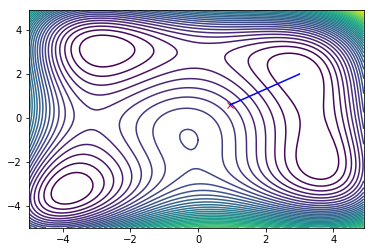

In [6]:
delta = 0.1
minXY=-5.0
maxXY=5.0
nContour=50
alpha=0.01

def J(x,y):
    u"""
    Himmelblau's function
    see Himmelblau's function - Wikipedia, the free encyclopedia 
    http://en.wikipedia.org/wiki/Himmelblau%27s_function
    """
    return (x**2+y-11)**2+(x+y**2-7)**2

def CreateMeshData():
    x = np.arange(minXY, maxXY, delta)
    y = np.arange(minXY, maxXY, delta)
    X, Y = np.meshgrid(x, y)
    Z=[J(x,y) for (x,y) in zip(X,Y)]
    return(X,Y,Z)

def jacobi(x):
    dx = 4*x[0]**3 + 4*x[0]*x[1] - 42*x[0] +2*x[1]**2 -14
    dy = 2*x[0]**2 + 4*x[0]*x[1] + 4*x[1]**3 -26*x[1] -22
    return np.array([dx,dy])

def golden_section(x0,d0):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(1-t)*b + t*a
    c2=(1-t)*a + t*b
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 + c1*d0
        f1 = J(x1[0],x1[1])
        x2 = x0 + c2*d0
        f2 = J(x2[0],x2[1])
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=(1-t)*b + t*a
        else:
            a=c1
            b=b
            c1_=c2
            c2_=(1-t)*a + t*b
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = c1_
        c2 = c2_
        #print(num,a,b,c1,c2,abs(b-a))
    return a

def CG(start):
    result=[start]
    x0 = start
    d0 = -jacobi(x0)
    for k in range(10000):
        alpha = golden_section(x0,d0)
        x = x0 + alpha*d0
        result.append(x)
        d = jacobi(x)
        if(np.sqrt(np.sum(d**2))<0.001):
            print(k,"end")
            break
        p = -d + (np.dot(d.T,d)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
    return result

def golden_section_N(x0,G0):
    a0=-10
    b0=10
    t = 0.618 #golden_ratio
    a=a0
    b=b0
    c1=(1-t)*b + t*a
    c2=(1-t)*a + t*b
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(1000):
        num+=1
        x1 = x0 - c1*G0@jacobi(x0)
        f1 = J(x1[0],x1[1])
        #f1 = f(c1)
        x2 = x0 - c2*G0@jacobi(x0)
        f2 = J(x2[0],x2[1])
        #f2 = f(c2)
        if(f2>f1):
            a=a
            b=c2
            c2_=c1
            c1_=(1-t)*b + t*a
        else:
            a=c1
            b=b
            c1_=c2
            c2_=(1-t)*a + t*b
        if(abs(b-a)<0.0001):
            #print(num,"end")
            break
        c1 = c1_
        c2 = c2_
        #print(num,a,b,c1,c2,abs(b-a))
    return a  

def quasi_Newton(start):
    I=np.eye(2)
    G0=np.eye(2)
    x0 = start
    result=[start]
    for k in range(10000):
        alpha = golden_section_N(x0,G0)
        x = x0 - alpha*G0@jacobi(x0)
        
        result.append(x)
        if(np.sqrt(np.sum(jacobi(x)**2))<0.001):
            print(k,"end")
            break
        p0 = x - x0
        q0 = jacobi(x) - jacobi(x0)
        print(p0,q0)
        #p0 = p0.reshape(-1,1)
        #q0 = q0.reshape(-1,1)
        G = (I - p0@q0.T/q0.T@p0)@G0@(I - q0@p0.T/q0.T@p0) + p0@p0.T/q0.T@p0
        print(G)
        G0 = G
        x0 = x
        
    return result
        
start=np.array([random.uniform(minXY,maxXY),random.uniform(minXY,maxXY)])

resultn=quasi_Newton(start)
resultc=CG(start)
(X,Y,Z)=CreateMeshData()
CS = plt.contour(X, Y, Z,nContour)
#  plt.clabel(CS, inline=1, fontsize=10)
#  plt.title('Simplest default with labels')

plt.plot(start[0],start[1],"xr");

if(len(resultn)<1000):
    optX=[x[0] for x in resultn]
    optY=[x[1] for x in resultn]
    plt.plot(optX,optY,"-r");

optX=[x[0] for x in resultc]
optY=[x[1] for x in resultc]
plt.plot(optX,optY,"-b");

plt.show()

In [6]:
def makecsv(m,F,df,fname):
    h=0.05
    t=0.0
    N=40
    
    Xa = np.full((N),F)
    Xa[19] += df
    
    X = []
    time = []
    
    for i in np.arange(1,m):
        Xb = Rungekutta4(Xa,h,F)
        Xa=Xb
        t=t+h
        if i > 1460:
            X.append(Xa)
            time.append(t)
        
    df=pd.DataFrame(X)
    df.to_csv(fname,index=False)
    
    dataset = pd.read_csv(fname)
    print(dataset)
    array = dataset.values
    #print(array)
    
    return array

             0         1          2         3         4         5         6  \
0    -4.577655 -2.752373   0.099049  0.677744  5.934551 -0.679750 -2.954209   
1    -3.492238 -2.382872  -0.132460  1.021116  5.995053 -1.253493 -2.160478   
2    -1.737512 -2.129497  -0.155935  1.296183  6.018508 -1.643000 -1.247249   
3     0.132688 -1.731283   0.028431  1.592421  5.997327 -1.819359 -0.291257   
4     1.660538 -1.145299   0.355962  1.971286  5.920252 -1.806988  0.611892   
5     2.613184 -0.497191   0.727151  2.440736  5.775701 -1.667487  1.387096   
6     2.985288  0.076291   1.083551  2.970887  5.556828 -1.471157  2.000461   
7     2.902180  0.527611   1.426230  3.527653  5.259192 -1.275429  2.454620   
8     2.533719  0.894443   1.785871  4.085551  4.872934 -1.115909  2.770881   
9     2.059085  1.242739   2.197940  4.620592  4.377801 -1.004464  2.972569   
10    1.652102  1.619169   2.693192  5.097779  3.745427 -0.928768  3.077689   
11    1.456050  2.045040   3.288462  5.459081  2.951

            0         1          2         3         4         5         6   \
0    -2.878039  0.591952   0.495855  5.181551  2.075622 -3.674536 -1.694007   
1    -2.190684 -2.247978   0.509388  4.682070  1.510716 -0.271545 -1.146887   
2    -1.532801 -0.987649   1.540610  2.525423  1.563944 -2.766673 -1.431760   
3    -0.748637 -1.277241  -0.372908  5.142575  1.710272 -0.171932  1.561375   
4    -0.404949 -1.918470   1.159875  3.097536  0.991758 -0.066493 -0.493602   
5     0.524430  1.251875   1.061251  4.491702  1.892137  0.604550  0.167412   
6     0.826726  1.459632   2.836240  3.173636 -0.361486  1.409252  0.953429   
7     1.847076  1.436641   3.696785  5.857123  2.476929 -0.454759  3.477741   
8     0.490926  2.459326   2.031457  5.678224  2.648774  1.111371  3.828426   
9     3.240344  2.895107   3.840058  1.817501  2.793296  0.351338  2.118861   
10    0.700037  4.325723   2.857514  5.657431  2.183521  2.233725  5.538915   
11    1.694730  3.683729   4.045428  6.287113  2.524

[[0 1 2 3 4]
 [5 6 7 8 9]] [[ 1  3  5  7  4]
 [11 13 15 17 14]]
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]]


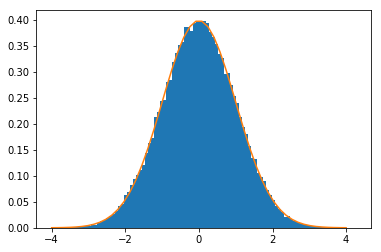

In [46]:
fname="data2.csv"
data = makecsv(2921,8.0,0.008,fname).reshape(1460,-1)
obdata = (data + np.roll(data,-1,axis=1))/2
N = obdata.size
R = []
x = np.linspace(-40,40)
x = x * 0.1
y = np.exp(-x*x/2)/np.sqrt(2*np.pi)
for i in range(N):
    R.append(random.normalvariate(0.0,1.0))
plt.hist(R,bins=100,density=True)
plt.plot(x,y)
oberr = np.array(R).reshape(obdata.shape)
for i in range(1460):
    obdata[i] += oberr[i]
    
df=pd.DataFrame(obdata)
print(df)
df.to_csv("observation_data2.csv",index=False)

d = np.arange(10).reshape(2,5)
d2 = d + np.roll(d,-1,axis=1)
print(d,d2)
H = np.eye(10)
H2 = H/2 + np.roll(H,1,axis=1)/2
print(H2)

             0         1          2         3         4         5         6  \
0    -4.577655 -2.752373   0.099049  0.677744  5.934551 -0.679750 -2.954209   
1    -3.492238 -2.382872  -0.132460  1.021116  5.995053 -1.253493 -2.160478   
2    -1.737512 -2.129497  -0.155935  1.296183  6.018508 -1.643000 -1.247249   
3     0.132688 -1.731283   0.028431  1.592421  5.997327 -1.819359 -0.291257   
4     1.660538 -1.145299   0.355962  1.971286  5.920252 -1.806988  0.611892   
5     2.613184 -0.497191   0.727151  2.440736  5.775701 -1.667487  1.387096   
6     2.985288  0.076291   1.083551  2.970887  5.556828 -1.471157  2.000461   
7     2.902180  0.527611   1.426230  3.527653  5.259192 -1.275429  2.454620   
8     2.533719  0.894443   1.785871  4.085551  4.872934 -1.115909  2.770881   
9     2.059085  1.242739   2.197940  4.620592  4.377801 -1.004464  2.972569   
10    1.652102  1.619169   2.693192  5.097779  3.745427 -0.928768  3.077689   
11    1.456050  2.045040   3.288462  5.459081  2.951

            0          1          2          3         4         5   \
0     3.577971   2.749079  -0.293983   0.598659  5.811769 -0.078188   
1     3.622472   2.604226  -1.616321   1.704935  3.346212  0.836169   
2     0.377964   1.865967   0.623538   0.639134  5.149351  1.959116   
3    -0.163420   2.602643   0.337258   3.100635  7.289955  1.336420   
4     0.714991   0.824683   2.194267   0.340867  7.132901  1.277738   
5     2.224730  -0.354322  -0.143807   3.209669  5.420135  3.099623   
6     1.400655   0.740373   1.614214   2.258896  7.277920  0.785106   
7     3.835424   1.307726   2.956769   0.226678  4.331141  0.730728   
8     1.425617  -0.177745   1.349140   4.904052  3.594727  1.001473   
9     1.778208   2.348198   2.550993   4.129699  5.132724  0.507164   
10    2.349295   1.553389   3.187882   4.647248  4.793212  1.517175   
11    1.056467   0.093178   4.931305   4.050894  4.047635  1.557160   
12    3.266491   1.282032   4.048892   4.797808  1.352703  0.593656   
13    

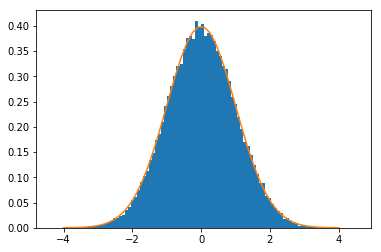

In [7]:

fname="data3.csv"
data = makecsv(2921,8.0,0.008,fname).reshape(1460,-1)
obdata = np.sqrt(data*data)
N = obdata.size
R = []
x = np.linspace(-40,40)
x = x * 0.1
y = np.exp(-x*x/2)/np.sqrt(2*np.pi)
for i in range(N):
    R.append(random.normalvariate(0.0,1.0))
plt.hist(R,bins=100,density=True)
plt.plot(x,y)
oberr = np.array(R).reshape(obdata.shape)
for i in range(1460):
    obdata[i] += oberr[i]
#obdata[obdata<0]=0.0
df=pd.DataFrame(obdata)
print(df)
df.to_csv("observation_data3.csv",index=False)


[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]
[[1.         0.60653066 0.13533528 ... 0.011109   0.13533528 0.60653066]
 [0.60653066 1.         0.60653066 ... 0.         0.011109   0.13533528]
 [0.13533528 0.60653066 1.         ... 0.         0.         0.011109  ]
 ...
 [0.011109   0.         0.         ... 1.         0.60653066 0.13533528]
 [0.13533528 0.011109   0.         ... 0.60653066 1.         0.60653066]
 [0.60653066 0.13533528 0.011109   ... 0.13533528 0.60653066 1.        ]]


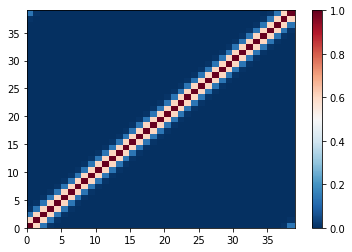

In [14]:
N=40
a=0
p=N-a
sigma=1.0
D = np.zeros((N,p))
L = np.zeros((N,p))

for s in range(N):
    for u in range(N-a):
        D[s,u] = min(abs(s-u),N-abs(s-u))
print(D)        
A=D>5
#print(A)
#print(D[A])
d0=2*np.sqrt(10/3)*sigma
r0=np.exp(-d0**2/(2*sigma**2))
L=np.exp(-D**2/(2*sigma**2))
L[L<r0]=0
x=np.arange(p)
y=np.arange(N)
#P = L*Pf
print(L)
plt.pcolor(x,y,L,cmap='RdBu_r')
plt.colorbar()
#plt.title("L*Pf")
#plt.show()

In [12]:
A = np.array([1,2,0,-3,4,5,0,-6,7,0,8,9]).reshape(3,4)
b = np.array([1,-1,1])
mask = np.empty(A.shape)
m = mask.shape[0]
for i in range(m):
    if(b[i]>0):
        mask[i]=True
    else:
        mask[i]=False
mask = b>0
print(mask)
print(A,A[mask])

[ True False  True]
[[ 1  2  0 -3]
 [ 4  5  0 -6]
 [ 7  0  8  9]] [[ 1  2  0 -3]
 [ 7  0  8  9]]


In [8]:
#3dVar
def L96(Xa,F):
    N=len(Xa)
    
    F_ = (np.roll(Xa, -1) - np.roll(Xa, 2)) * np.roll(Xa, 1) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    N=len(Xa)
    #K1=np.linspace(1,N,N)
    #K2=np.linspace(1,N,N)
    #K3=np.linspace(1,N,N)
    #K4=np.linspace(1,N,N)
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb


def J(x,B_inv,H_t,R_inv,d):
    return x.T@B_inv@x/2 + (H_t@x-d).T@R_inv@(H_t@x-d)/2

def jacobi(x,B_inv,H_t,R_inv,d):
    return B_inv@x + H_t.T@R_inv@(H_t@x-d)

def CG(xb,B_inv,H_t,R_inv,d):
    x0 = xb
    d0 = -jacobi(x0,B_inv,H_t,R_inv,d)
    for k in range(1000):
        alpha = golden_section(d0,x0,B_inv,H_t,R_inv,d)
        x = x0 + alpha*d0
        d1 = jacobi(x,B_inv,H_t,R_inv,d)
        err = np.sqrt(np.sum(d1**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d1**2))<0.001):
            #print(k,"end")
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        x0 = x
        d0 = p
    return x

def golden_section(d0,x0,B_inv,H_t,R_inv,d):
    a0=0
    b0=10
    t = (1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=(t*a+b)/(1+t)
    c2=(a+t*b)/(1+t)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(100):
        num+=1
        x1 = x0 + c1*d0
        f1 = J(x1,B_inv,H_t,R_inv,d)
        x2 = x0 + c2*d0
        f2 = J(x2,B_inv,H_t,R_inv,d)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=(t*a+b)/(1+t)
        else:
            a=c1
            b=b
            c1=c2
            c2=(a+t*b)/(1+t)
        if(abs(b-a)<0.0001):
            #print(num,"end",a)
            break
        #print(num,a,b,c1,c2,abs(b-a))
    return a

def J_c(dv,U,H_t,R_inv,d):
    return dv.T@dv/2 + (H_t@U@dv-d).T@R_inv@(H_t@U@dv-d)/2

def jacobi_c(dv,U,H_t,R_inv,d):
    return dv + U.T@H_t.T@R_inv@(H_t@U@dv-d)

def CG_c(dv0,U,H_t,R_inv,d):
    d0 = -jacobi(dv0,U,H_t,R_inv,d)
    for k in range(1000):
        alpha = golden_section(d0,dv0,U,H_t,R_inv,d)
        dv = dv0 + alpha*d0
        d1 = jacobi(dv,U,H_t,R_inv,d)
        err = np.sqrt(np.sum(d1**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d1**2))<0.001):
            #print(k,"end")
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        dv0 = dv
        d0 = p
    return dv

def golden_section_c(d0,dv0,U,H_t,R_inv,d):
    a0=0
    b0=10
    t = (1+np.sqrt(5))/2#golden_ratio
    a=a0
    b=b0
    c1=(t*a+b)/(1+t)
    c2=(a+t*b)/(1+t)
    num=0
    #print(num,a,b,c1,c2,abs(b-a))
    for k in range(100):
        num+=1
        dv1 = dv0 + c1*d0
        f1 = J(dv1,U,H_t,R_inv,d)
        dv2 = dv0 + c2*d0
        f2 = J(dv2,U,H_t,R_inv,d)
        if(f2>f1):
            a=a
            b=c2
            c2=c1
            c1=(t*a+b)/(1+t)
        else:
            a=c1
            b=b
            c1=c2
            c2=(a+t*b)/(1+t)
        if(abs(b-a)<0.0001):
            #print(num,"end",a)
            break
        #print(num,a,b,c1,c2,abs(b-a))
    return a



def H3(X,mask):
    X_=X[mask]
    return np.sqrt(X_*X_)
def H3_t(X,dX,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Ht = H[mask]
    return Ht@dX
def H3_adj(X,dY,mask):
    H = np.diag(np.sqrt(X*X)/X)
    Hadj = H[mask].T
    return Hadj@dY

def Forecast(Xa,B):
    h = 0.05
    F = 8.0
    a = 1.1
    
    X1 = Xa
    M = np.eye(N)
    #for i in range(5):
    Xf = Rungekutta4(X1,h,F)
        #M_ = get_linear(X1,h,F)
        #M = M_ @ M
    X1 = Xf
    
    #M = get_linear(Xa,h,F,N)
    #Pf = M @ Pa @ M.T #カルマンフィルターでは時間発展する、3次元変分法では定数
    Pf = B
    
    return Xf,Pf

def Analysis(Xf,Pf,y):
    H = np.eye(N)
    H2 = H/2 + np.roll(H,1,axis=1)/2
    mask = y>=0
    y_ = y[mask]
    e = np.ones(N)
    p = int(np.sum(e[mask]))
    #R = np.eye(p)
    R = np.eye(N)
    I = np.eye(N)
    
    
    d = y - H @ Xf
    #d = y_ - H3(Xf,mask)
    R_inv=np.linalg.inv(R)
    B_inv=np.linalg.inv(Pf)
    
    Ex = np.eye(N)
    Ey = np.eye(p)
    H3t=np.zeros((N,p))
    H3adj=np.zeros((p,N))
    for i in range(N):
        H3t[i] = H3_t(Xf,Ex[i],mask)
    for i in range(p):
        H3adj[i] = H3_adj(Xf,Ey[i],mask)
    H3t = H3t.T
    H3adj = H3adj.T
    #print(H3t,H3adj)
   
    xb=np.zeros(N)
    U = np.linalg.cholesky(B) #cholesky decomposition
    dv0 = np.zeros(N)
    #X = CG(xb,B_inv,H,R_inv,d)
    dv = CG_c(dv0,U,H,R_inv,d)
    X = U@dv
    Xa = X + Xf
    
    return Xa

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
elapsed_time:7.562167167663574[sec]


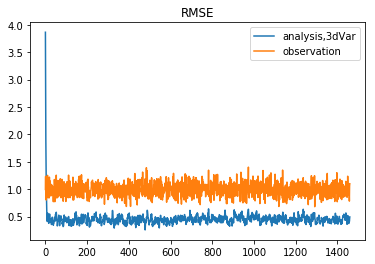

In [9]:
import time

start = time.time()

t = 1460
N = 40
h = 0.05 
F = 8.0

X = []
P = []
Pt2 = []
P2 = []
errcov = []

dataset = pd.read_csv("observation_data.csv")
y = dataset.values
y = y.reshape(1460,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)

#初期値
Xa = np.random.randn(N)
X0 = Xa
for j in range(500):
    Xa = Rungekutta4(X0,h,F)
    X0 = Xa
B = np.eye(N) * 0.2
#print(Xa)
#print(B)
#X.append(Xa
    


for k in range(t):
    (Xf,Pf) = Forecast(Xa,B)
    Xa = Analysis(Xf,Pf,y[k,:])
    X.append(Xa)
    if(k%100==0):
        print(k)

elapsed_time = time.time()-start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

Xa = np.array(X)
#print(Xa)

C1_ = []
C2_ = []
H = np.eye(N)
H2 = H/2 + np.roll(H,1,axis=1)/2
for i in range(1460):
    X1 = Xa[i]
    X2 = Xt[i]
    X3 = sum((X2-X1)*(X2-X1))/N
    Y1 = y[i]
    #mask = Y1>=0
    #Y1 = Y1[mask]
    #e = np.eye(N)
    #p = int(np.sum(e[mask]))
    Y2 = sum((H@X2-Y1)*(H@X2-Y1))/N
    #Y2 = sum((H3(X2,mask)-Y1)*(H3(X2,mask)-Y1))/p
    rmse1 = np.sqrt(X3)
    rmse2 = np.sqrt(Y2)
    C1_.append(rmse1)
    C2_.append(rmse2)
#plt.plot(C1,label="analysis,OI")
plt.plot(C1_,label="analysis,3dVar")
plt.plot(C2_,label="observation")
#plt.plot(errcov,label="Pa")
plt.legend()
plt.title("RMSE")
#plt.savefig("3dVar-OI_3.jpg")
plt.show()